In [262]:
import statsmodels.formula.api as smf
from statsmodels.discrete.discrete_margins import margeff
from scipy.special import expit
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Dataset preparation

In [266]:
# Load dataset


file_name = 'structured_donation_choices_llama3_full.csv' # 'structured_donation_choices.csv'

#file_name = 'structured_donation_choices_open.csv'

df = pd.read_csv(file_name)

# Keep only rows where a clear option was chosen
df = df[df['chosen_option'].isin(['Option A', 'Option B'])].copy()

# Define donation-related fields to extract from chosen option
fields = ['gender', 'age', 'identifiability', 'relatedness', 'num_recipients', 
          'cause', 'brand', 'location']

# Extract chosen attributes based on 'chosen_option'
for field in fields:
    df[f'don_{field}'] = df.apply(
        lambda row: row[f"A_{field}"] if row['chosen_option'] == 'Option A'
        else row[f"B_{field}"], axis=1
    )

# Add a unified region column

try:
    df['don_region'] = df.apply(
        lambda row: row['option_A_region'] if row['chosen_option'] == 'Option A'
        else row['option_B_region'], axis=1)
    
except: 
    df['don_region'] = df.apply(
        lambda row: row['optA_region'] if row['chosen_option'] == 'Option A'
        else row['optB_region'], axis=1)   
    

# Drop A_ and B_ prefixed columns and option_X_region
drop_cols = [col for col in df.columns if col.startswith('A_') or col.startswith('B_') or col.startswith('option_')]
df = df.drop(columns=drop_cols)

# Optional: inspect the cleaned dataframe
print(df.columns.tolist())
df.head()


# Prepare binary target
df['chosen_option'] = df['chosen_option'].map({'Option A': 1, 'Option B': 0})


['age', 'gender', 'income', 'education', 'political_leaning', 'religious_level', 'donated_before', 'donation_frequency', 'trust_charities', 'charities_rated_by_effectiveness', 'objective_measures_help', 'charities_match_my_values', 'country', 'province', 'chosen_option', 'don_gender', 'don_age', 'don_identifiability', 'don_relatedness', 'don_num_recipients', 'don_cause', 'don_brand', 'don_location', 'don_region']


In [264]:
df['chosen_option'].value_counts()

0    17175
1     6517
Name: chosen_option, dtype: int64

In [265]:
df.to_csv('clean_data_llama3.csv', index=False)

In [246]:
print(df.columns.to_list())
print(len(df))

['age', 'gender', 'income', 'education', 'political_leaning', 'religious_level', 'donated_before', 'donation_frequency', 'trust_charities', 'charities_rated_by_effectiveness', 'objective_measures_help', 'charities_match_my_values', 'country', 'province', 'chosen_option', 'don_gender', 'don_age', 'don_identifiability', 'don_relatedness', 'don_num_recipients', 'don_cause', 'don_brand', 'don_location', 'don_region']
22462


In [247]:
# # 1. Prepare the dataset
# # df_ame = df[['chosen_option', 'don_gender', 'don_age', 'don_cause', 
# #              'don_brand', 'don_identifiability', 'don_num_recipients', 'don_location']].copy()

# # Keep all columns from the original DataFrame
# df_ame = df.copy()

# # Drop 'don_relatedness' from the dataset
# df_ame = df_ame.drop(columns=['don_relatedness'])

# # # Rename for formula compatibility
# # df_ame = df_ame.rename(columns={'chosen_option_binary': 'chosen_option'})

# # Fallback values for empty columns
# fallback_values = {
#     'don_age': ['child', 'adult', 'elderly'],
#     'don_identifiability': ['named', 'unnamed'],
#     'don_brand': ['high-recognition', 'low-recognition', 'no-brand']
# }

# # Function to fill NAs using distribution or fallback
# def safe_fill_na_with_distribution(column, fallback=None):
#     non_na_values = column.dropna()
#     if len(non_na_values) == 0 and fallback:
#         return column.apply(lambda x: np.random.choice(fallback))
#     elif column.dtype == 'O' or column.dtype.name == 'category':
#         probs = non_na_values.value_counts(normalize=True)
#         return column.apply(lambda x: np.random.choice(probs.index, p=probs.values) if pd.isna(x) else x)
#     else:
#         return column.apply(lambda x: np.random.choice(non_na_values.values) if pd.isna(x) else x)

# # Apply filling logic
# columns_to_fill = ['don_gender', 'don_age', 'don_cause', 'don_brand',
#                    'don_identifiability', 'don_num_recipients', 'don_location']

# for col in columns_to_fill:
#     fallback = fallback_values.get(col, None)
#     df_ame[col] = safe_fill_na_with_distribution(df_ame[col], fallback=fallback)
 
# df_ame['chosen_option'] = df_ame['chosen_option'].map({'Option A': 1, 'Option B': 0}).astype(float)






In [248]:
df_ame.columns

Index(['age', 'gender', 'income', 'education', 'political_leaning',
       'religious_level', 'donated_before', 'donation_frequency',
       'trust_charities', 'charities_rated_by_effectiveness',
       'objective_measures_help', 'charities_match_my_values', 'country',
       'province', 'chosen_option', 'don_gender', 'don_age',
       'don_identifiability', 'don_num_recipients', 'don_cause', 'don_brand',
       'don_location', 'don_region'],
      dtype='object')

## Gender

In [259]:
# Re-import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


# Fill missing values as before
fallback_values = {
    'don_age': ['child', 'adult', 'elderly'],
    'don_identifiability': ['named', 'unnamed'],
    'don_brand': ['high-recognition', 'low-recognition', 'no-brand']
}

def safe_fill_na_with_distribution(column, fallback=None):
    non_na_values = column.dropna()
    if len(non_na_values) == 0 and fallback:
        return column.apply(lambda x: np.random.choice(fallback))
    elif column.dtype == 'O' or column.dtype.name == 'category':
        probs = non_na_values.value_counts(normalize=True)
        return column.apply(lambda x: np.random.choice(probs.index, p=probs.values) if pd.isna(x) else x)
    else:
        return column.apply(lambda x: np.random.choice(non_na_values.values) if pd.isna(x) else x)

# Drop completely missing numeric columns
df = df.drop(columns=['don_relatedness']) if 'don_relatedness' in df.columns else df
for col in df.columns:
    fallback = fallback_values.get(col)
    df[col] = safe_fill_na_with_distribution(df[col], fallback)


/Users/rajasunkara/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rajasunkara/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rajasunkara/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rajasunkara/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


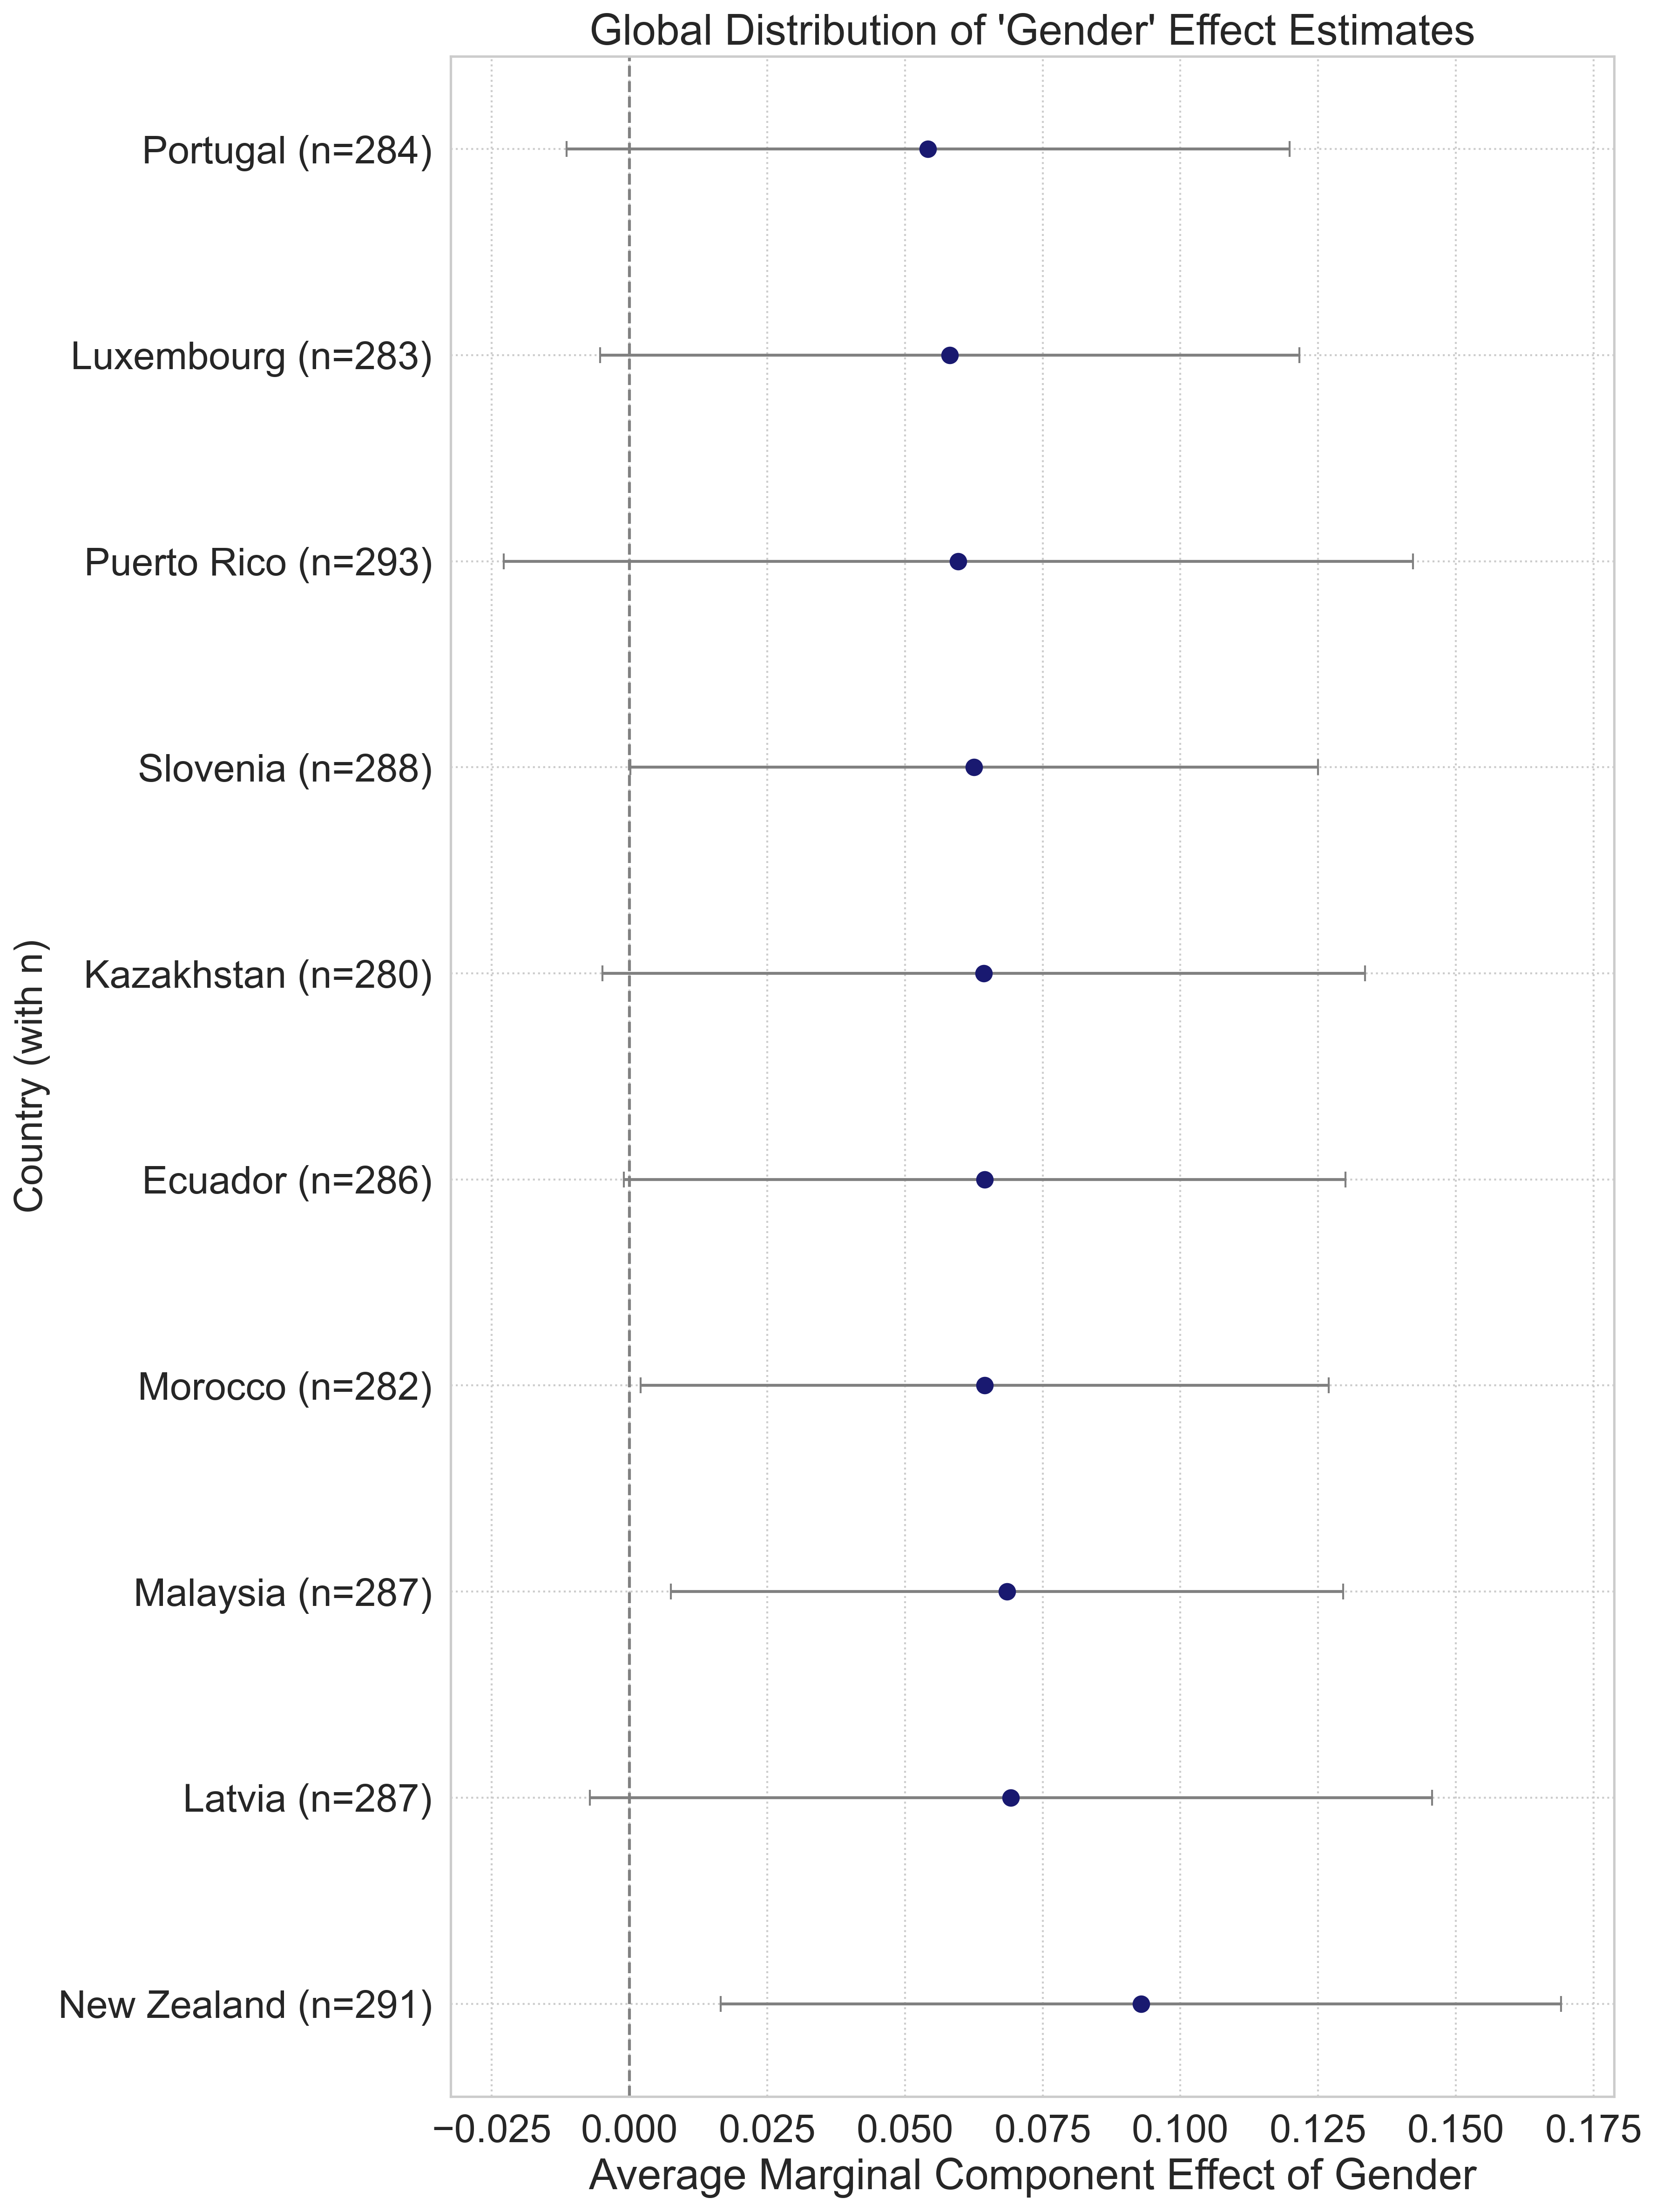

In [250]:
# Run logistic regressions by country and compute AMEs for gender
ame_results = []

for location in df['country'].unique():
    subdf = df[df['country'] == location]
    if subdf['don_gender'].nunique() < 2:
        continue
    try:
        model = smf.logit(
            formula='chosen_option ~ don_gender + C(don_age) + C(don_cause) + C(don_brand) + C(don_identifiability) + don_num_recipients',
            data=subdf
        ).fit(disp=False)
        me = model.get_margeff(at='overall', method='dydx', dummy=True)
        gender_effect = me.summary_frame().filter(like='don_gender', axis=0)

        ame_results.append({
            'location': location,
            'ame': gender_effect['dy/dx'].values.item(),
            'ci_low': gender_effect['Conf. Int. Low'].values.item(),
            'ci_high': gender_effect['Cont. Int. Hi.'].values.item(),
            'stderr': gender_effect['Std. Err.'].values.item(),
            'n': len(subdf)
        })
    except Exception:
        continue
# Convert results to DataFrame
ame_df = pd.DataFrame(ame_results)
ame_df['label'] = ame_df.apply(lambda row: f"{row['location']} (n={row['n']})", axis=1)
ame_df = ame_df.sort_values('ame',ascending=False).head(10)

# Plot with enhancements
plt.figure(figsize=(12, 16), dpi=300)
plt.errorbar(
    ame_df['ame'], ame_df['label'],
    xerr=[ame_df['ame'] - ame_df['ci_low'], ame_df['ci_high'] - ame_df['ame']],
    fmt='o', color='midnightblue', ecolor='gray', capsize=4, markersize=8
)
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Average Marginal Component Effect of Gender", fontsize=22)
plt.ylabel("Country (with n)", fontsize=20)
plt.title("Global Distribution of 'Gender' Effect Estimates", fontsize=22)
plt.grid(True, linestyle=':')
plt.yticks(fontsize=20)  # Adjust font size as needed
plt.xticks(fontsize=20)
plt.tight_layout()
plt.show()

## Cause

In [251]:
df['don_cause'].value_counts()

medication                5756
nutritious meals          5713
clean water               5568
assault victim support    5425
Name: don_cause, dtype: int64

/Users/rajasunkara/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rajasunkara/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rajasunkara/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rajasunkara/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


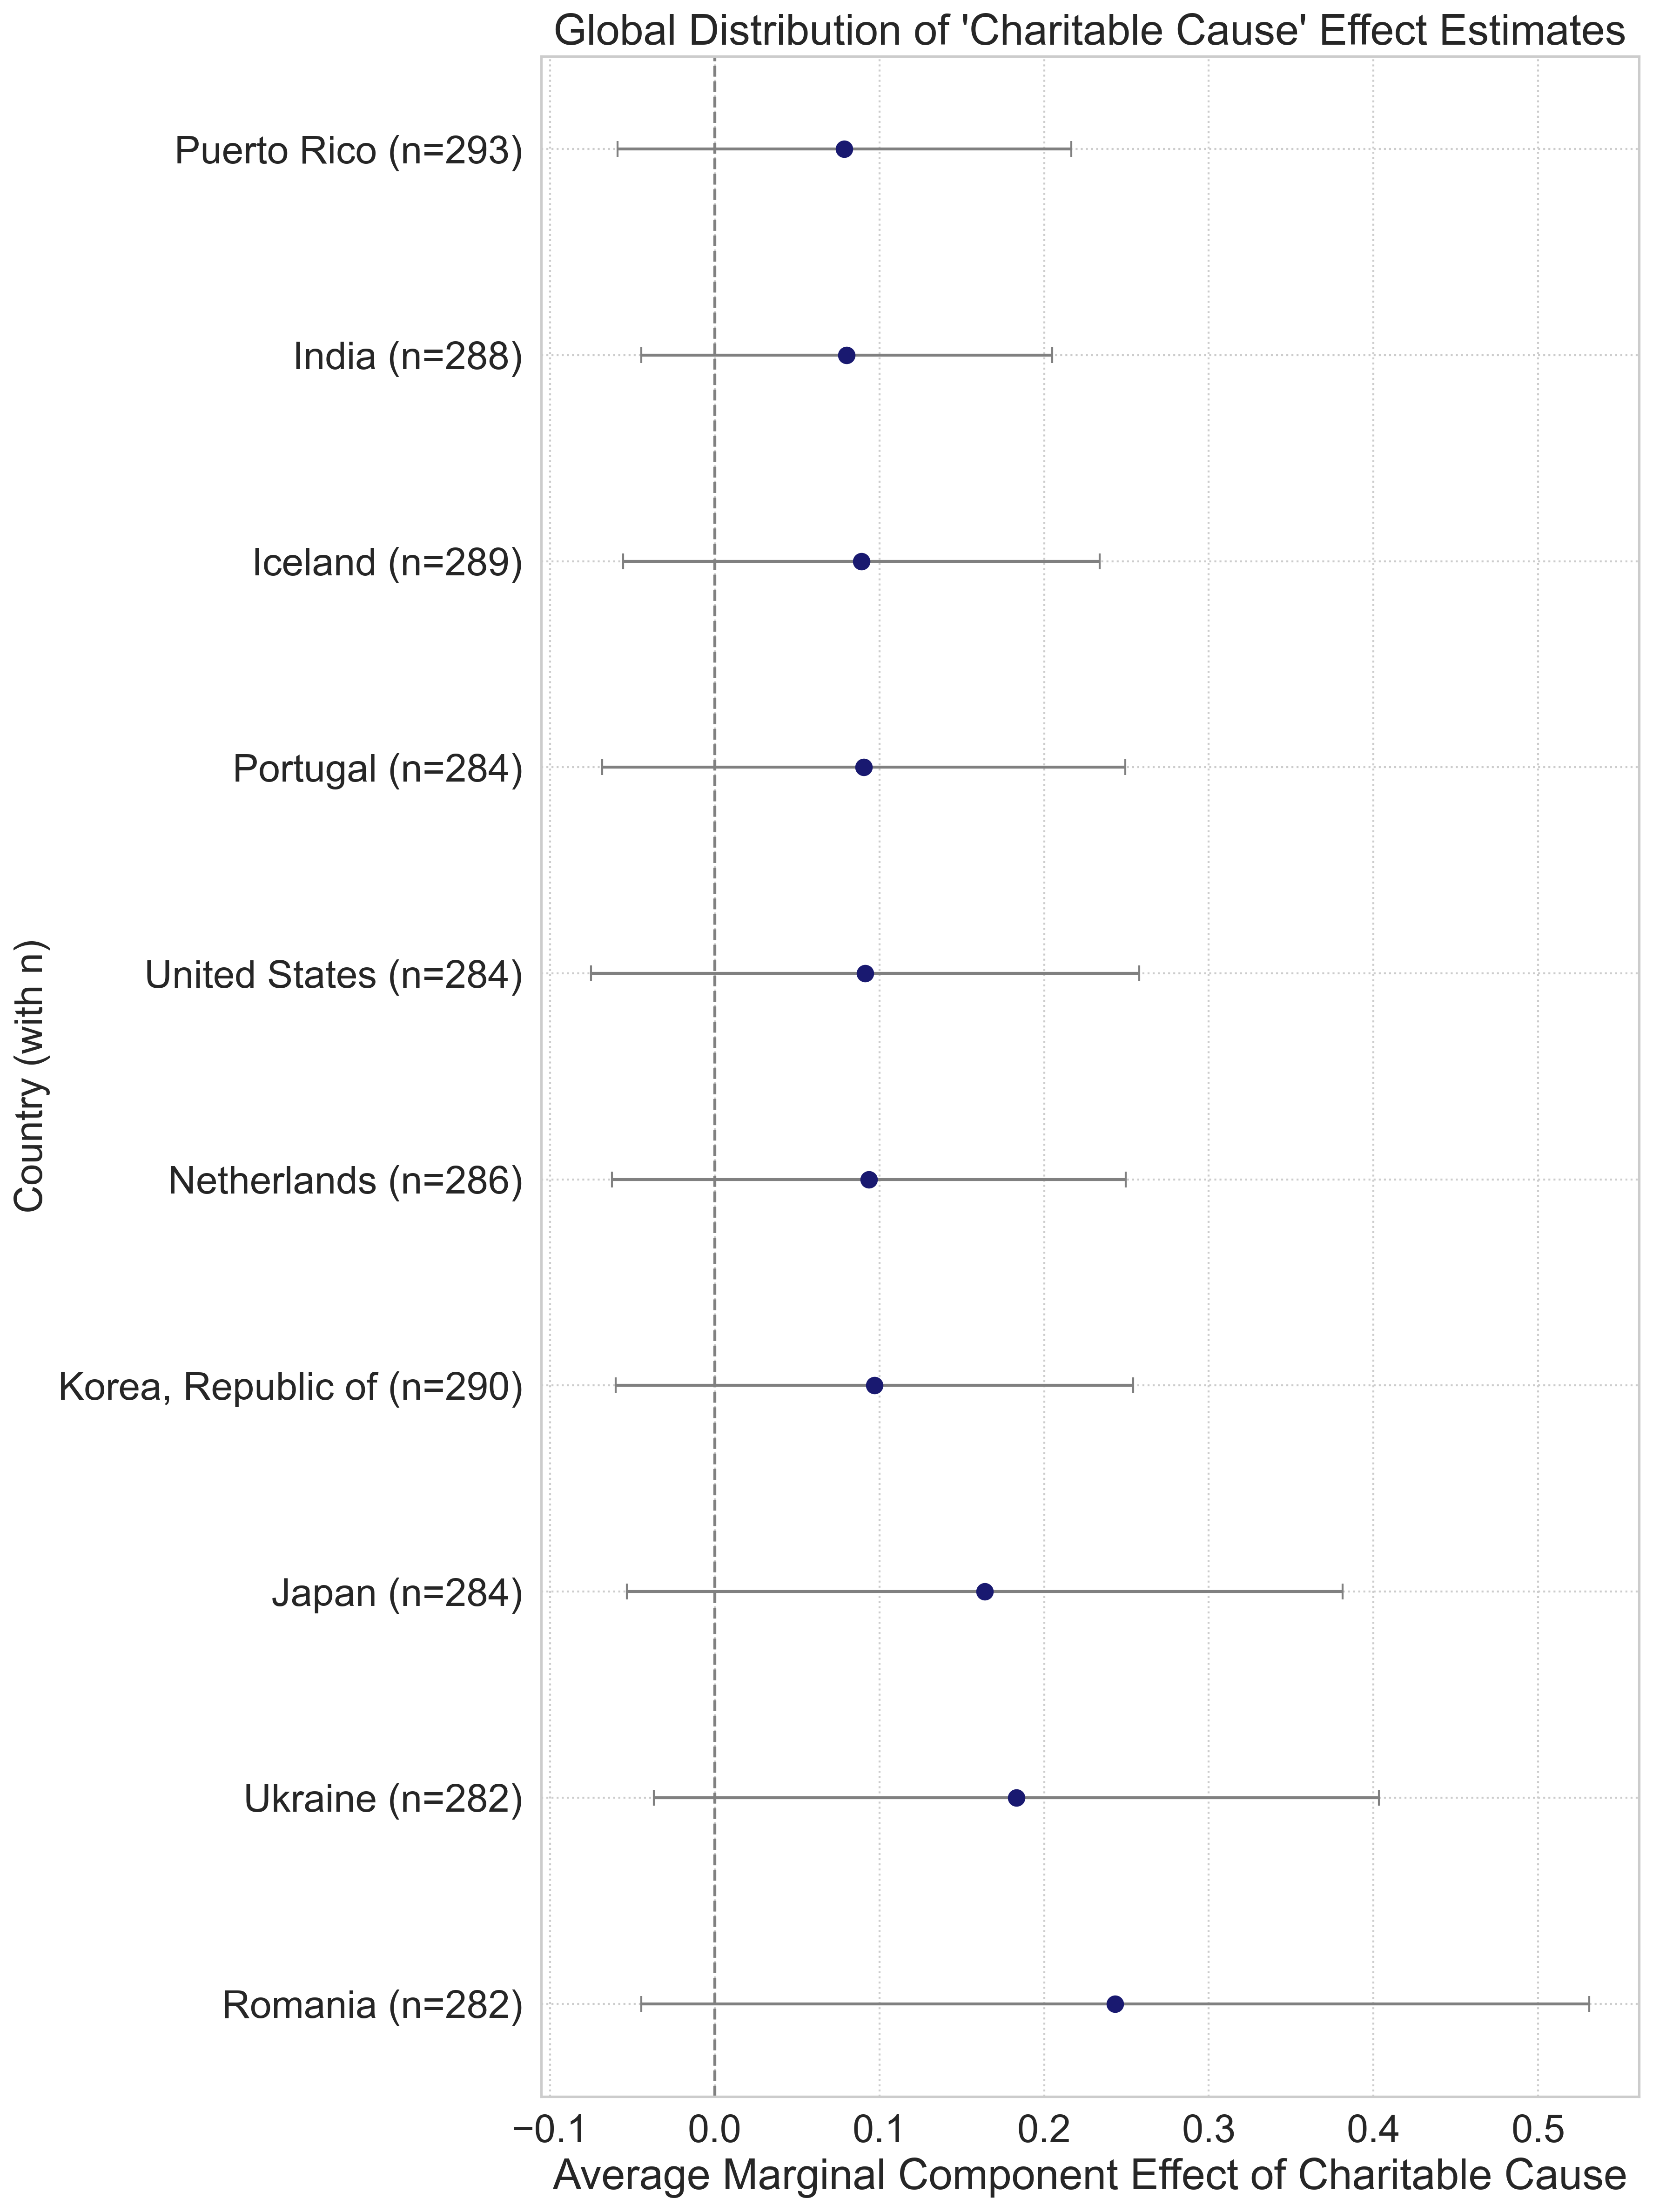

In [252]:

ame_results = []

for location in df['country'].unique():
    subdf = df[df['country'] == location]
    if subdf['don_gender'].nunique() < 2:
        continue
    try:
        model = smf.logit(
            formula='chosen_option ~ don_gender + C(don_age) + C(don_cause) + C(don_brand) + C(don_identifiability) + don_num_recipients',
            data=subdf
        ).fit(disp=False)
        me = model.get_margeff(at='overall', method='dydx', dummy=True)  
        # Get average of all marginal effects related to don_cause
        cause_mfx = me.summary_frame().filter(like='don_cause', axis=0)
        avg_ame = cause_mfx['dy/dx'].abs().mean()
        avg_se = cause_mfx['Std. Err.'].mean()
        ci_low = avg_ame - 1.96 * avg_se
        ci_high = avg_ame + 1.96 * avg_se

        ame_results.append({
            'location': location,
            'ame': avg_ame,
            'ci_low': ci_low,
            'ci_high': ci_high,
            'stderr': avg_se,
            'n': len(subdf)
        })
    except Exception:
        continue
# Convert results to DataFrame
ame_df = pd.DataFrame(ame_results)
ame_df['label'] = ame_df.apply(lambda row: f"{row['location']} (n={row['n']})", axis=1)
#ame_df = ame_df.sort_values('ame')



ame_df = ame_df.sort_values('ame',ascending=False).head(10)

# Plot with enhancements
plt.figure(figsize=(12, 16), dpi=300)
plt.errorbar(
    ame_df['ame'], ame_df['label'],
    xerr=[ame_df['ame'] - ame_df['ci_low'], ame_df['ci_high'] - ame_df['ame']],
    fmt='o', color='midnightblue', ecolor='gray', capsize=4, markersize=8
)
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Average Marginal Component Effect of Charitable Cause", fontsize=22)
plt.ylabel("Country (with n)", fontsize=20)
plt.title("Global Distribution of 'Charitable Cause' Effect Estimates", fontsize=22)
plt.grid(True, linestyle=':')
plt.yticks(fontsize=20)  # Adjust font size as needed
plt.xticks(fontsize=20)
plt.tight_layout()
plt.show()

# # Plot with enhancements
# plt.figure(figsize=(12, 16), dpi=300)
# plt.errorbar(
#     ame_df['ame'], ame_df['label'],
#     xerr=[ame_df['ame'] - ame_df['ci_low'], ame_df['ci_high'] - ame_df['ame']],
#     fmt='o', color='midnightblue', ecolor='gray', capsize=4, markersize=5
# )
# plt.axvline(0, color='gray', linestyle='--')
# plt.xlabel("Average Marginal Component Effect of Charitable Cause", fontsize=12)
# plt.ylabel("Country (with n)", fontsize=12)
# plt.title("Global Distribution of 'Charitable Cause' Effect Estimates", fontsize=14)
# plt.grid(True, linestyle=':')
# plt.tight_layout()
# plt.show()

## Brand

In [203]:
df['don_brand'].value_counts()

high-recognition    12008
low-recognition     11684
Name: don_brand, dtype: int64

/Users/rajasunkara/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rajasunkara/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rajasunkara/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rajasunkara/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


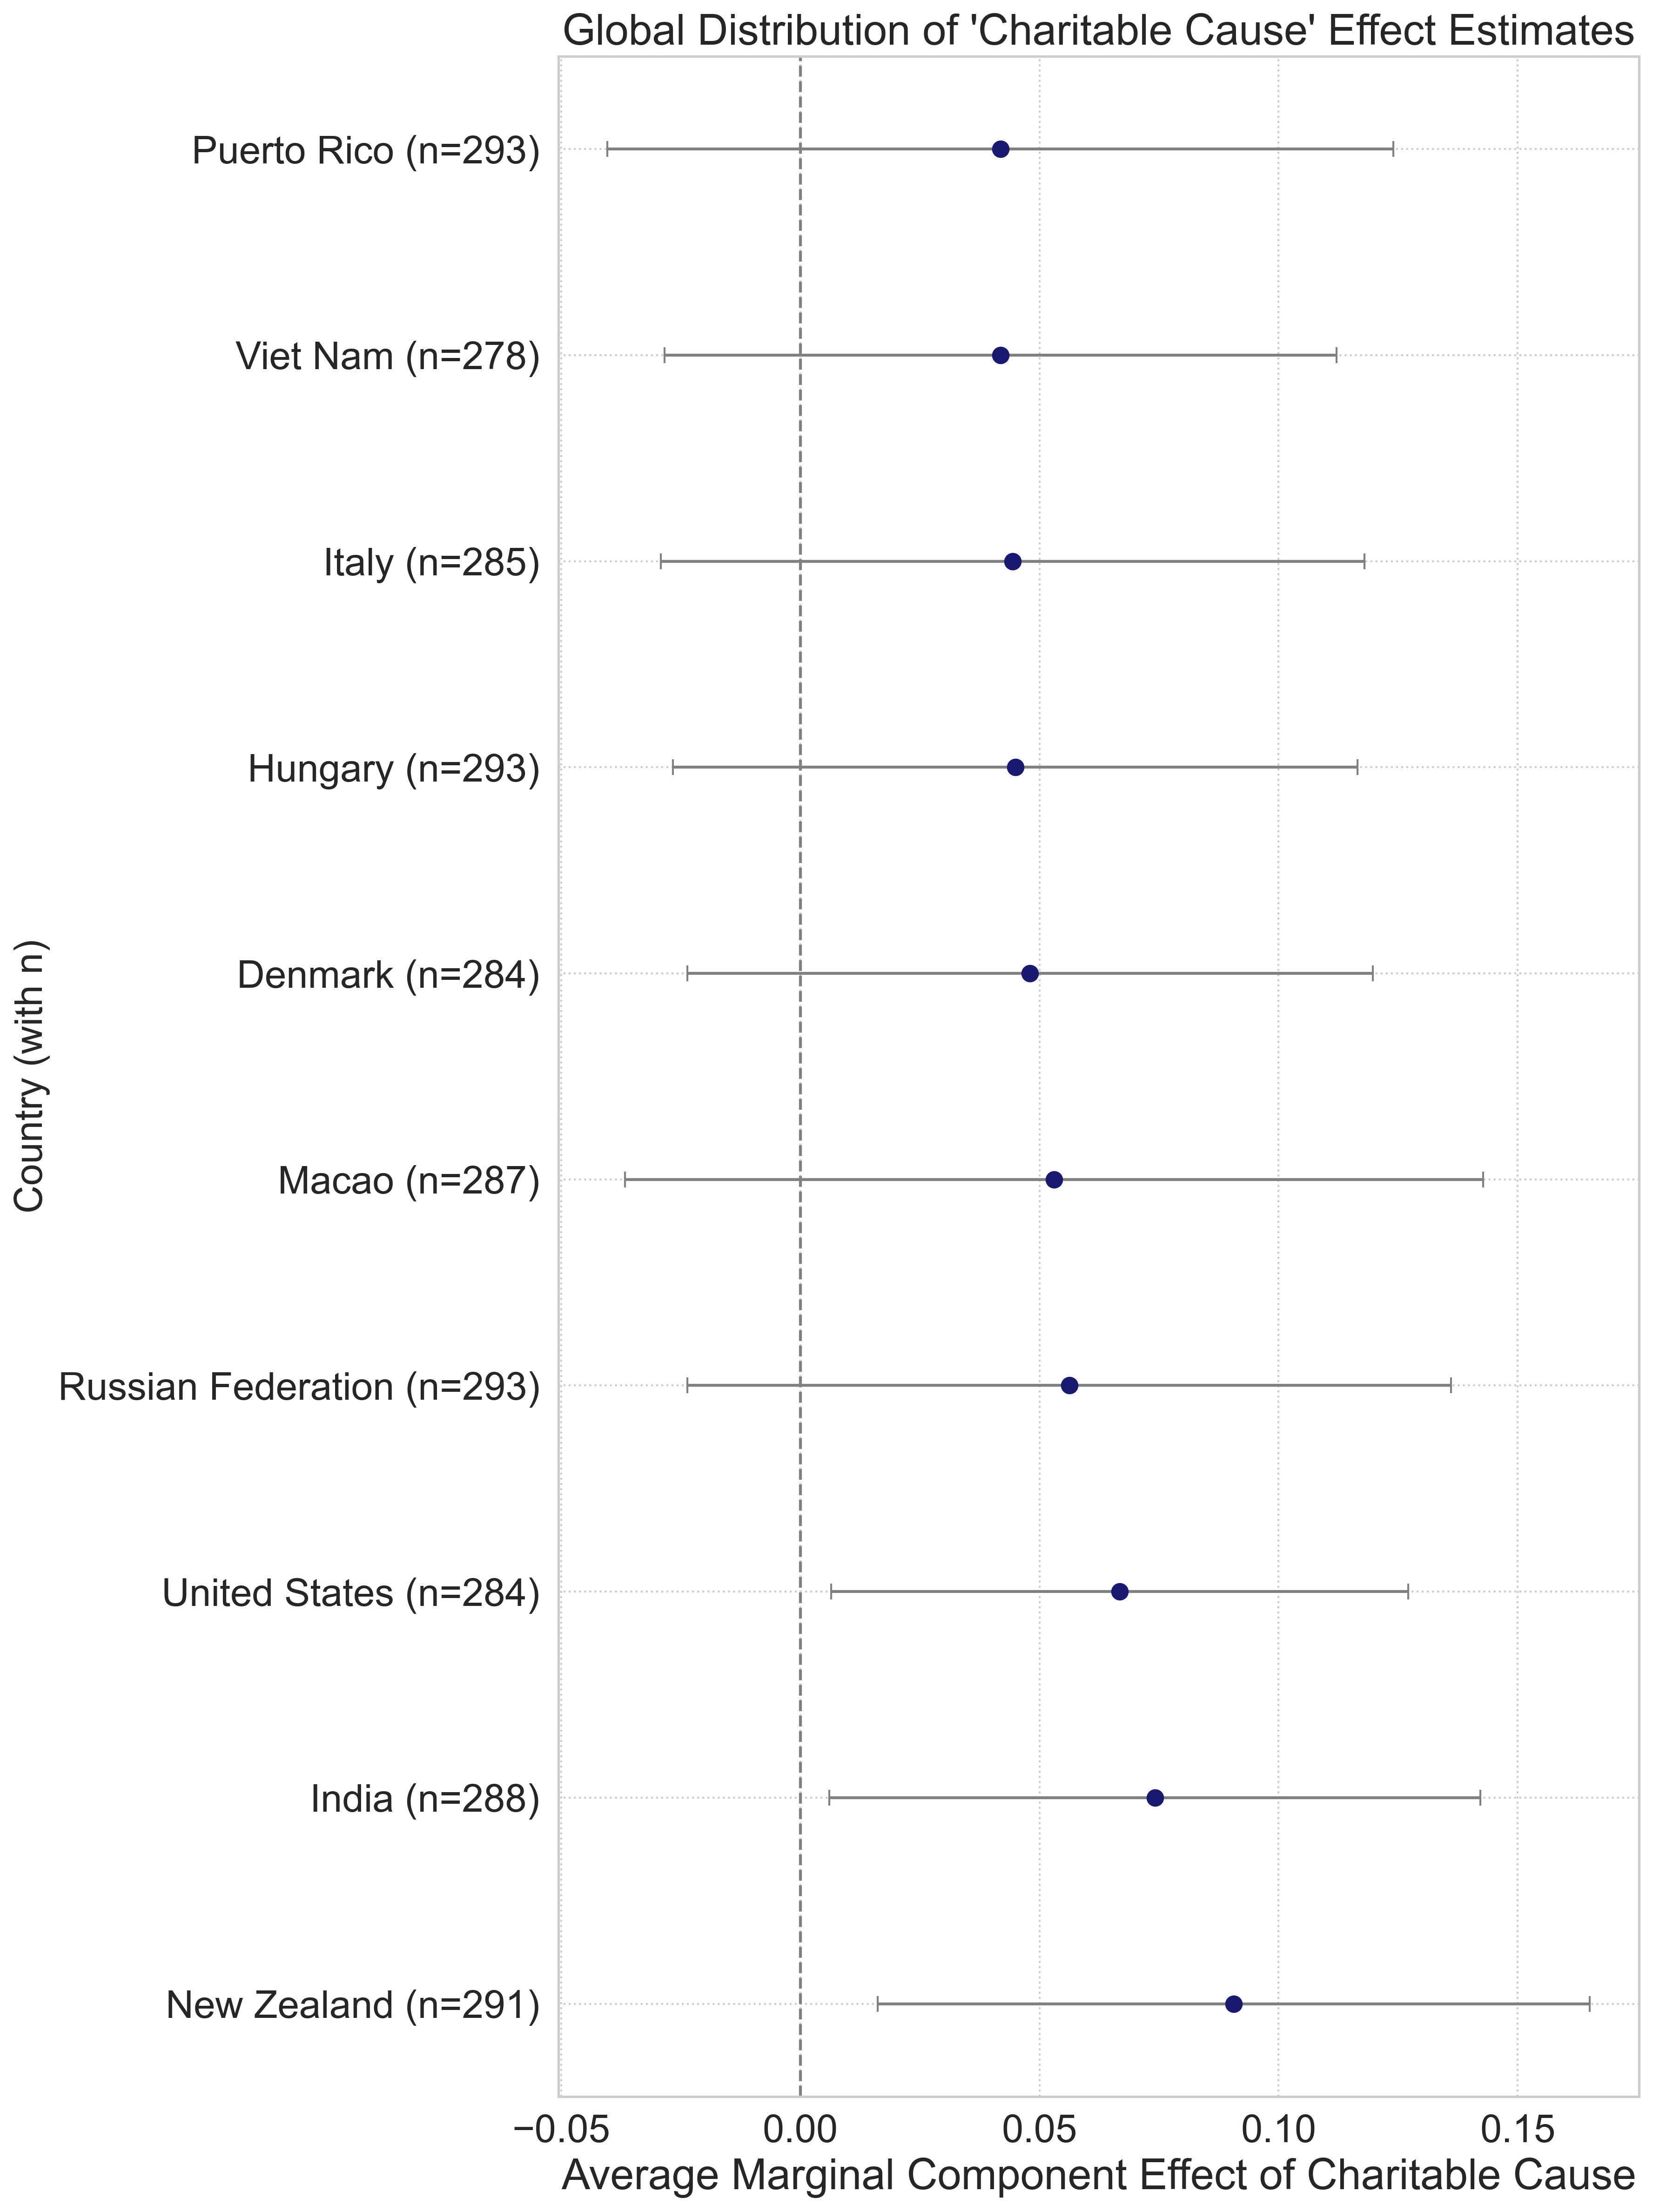

In [253]:
# Run logistic regressions by country and compute AMEs for gender
ame_results = []

for location in df['country'].unique():
    subdf = df[df['country'] == location]
    if subdf['don_gender'].nunique() < 2:
        continue
    try:
        model = smf.logit(
            formula='chosen_option ~ don_gender + C(don_age) + C(don_cause) + C(don_brand) + C(don_identifiability) + don_num_recipients',
            data=subdf
        ).fit(disp=False)
        me = model.get_margeff(at='overall', method='dydx', dummy=True)  
        # Get average of all marginal effects related to don_cause
        cause_mfx = me.summary_frame().filter(like='don_brand', axis=0)
        avg_ame = cause_mfx['dy/dx'].mean()
        avg_se = cause_mfx['Std. Err.'].mean()
        ci_low = avg_ame - 1.96 * avg_se
        ci_high = avg_ame + 1.96 * avg_se

        ame_results.append({
            'location': location,
            'ame': avg_ame,
            'ci_low': ci_low,
            'ci_high': ci_high,
            'stderr': avg_se,
            'n': len(subdf)
        })
    except Exception:
        continue
# Convert results to DataFrame
ame_df = pd.DataFrame(ame_results)
ame_df['label'] = ame_df.apply(lambda row: f"{row['location']} (n={row['n']})", axis=1)
#ame_df = ame_df.sort_values('ame')


ame_df = ame_df.sort_values('ame',ascending=False).head(10)

# Plot with enhancements
plt.figure(figsize=(12, 16), dpi=300)
plt.errorbar(
    ame_df['ame'], ame_df['label'],
    xerr=[ame_df['ame'] - ame_df['ci_low'], ame_df['ci_high'] - ame_df['ame']],
    fmt='o', color='midnightblue', ecolor='gray', capsize=4, markersize=8
)
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Average Marginal Component Effect of Charitable Cause", fontsize=22)
plt.ylabel("Country (with n)", fontsize=20)
plt.title("Global Distribution of 'Charitable Cause' Effect Estimates", fontsize=22)
plt.grid(True, linestyle=':')
plt.yticks(fontsize=20)  # Adjust font size as needed
plt.xticks(fontsize=20)
plt.tight_layout()
plt.show()

# # Plot with enhancements
# plt.figure(figsize=(12, 16), dpi=300)
# plt.errorbar(
#     ame_df['ame'], ame_df['label'],
#     xerr=[ame_df['ame'] - ame_df['ci_low'], ame_df['ci_high'] - ame_df['ame']],
#     fmt='o', color='midnightblue', ecolor='gray', capsize=4, markersize=5
# )
# plt.axvline(0, color='gray', linestyle='--')
# plt.xlabel("Average Marginal Component Effect of Charitable Brand", fontsize=12)
# plt.ylabel("Country (with n)", fontsize=12)
# plt.title("Global Distribution of 'Charitable Brand' Effect Estimates", fontsize=14)
# plt.grid(True, linestyle=':')
# plt.tight_layout()
# plt.show()

## Identifiability

In [205]:
df['don_identifiability'].value_counts()

unnamed    20428
named       3264
Name: don_identifiability, dtype: int64

/Users/rajasunkara/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rajasunkara/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rajasunkara/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rajasunkara/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


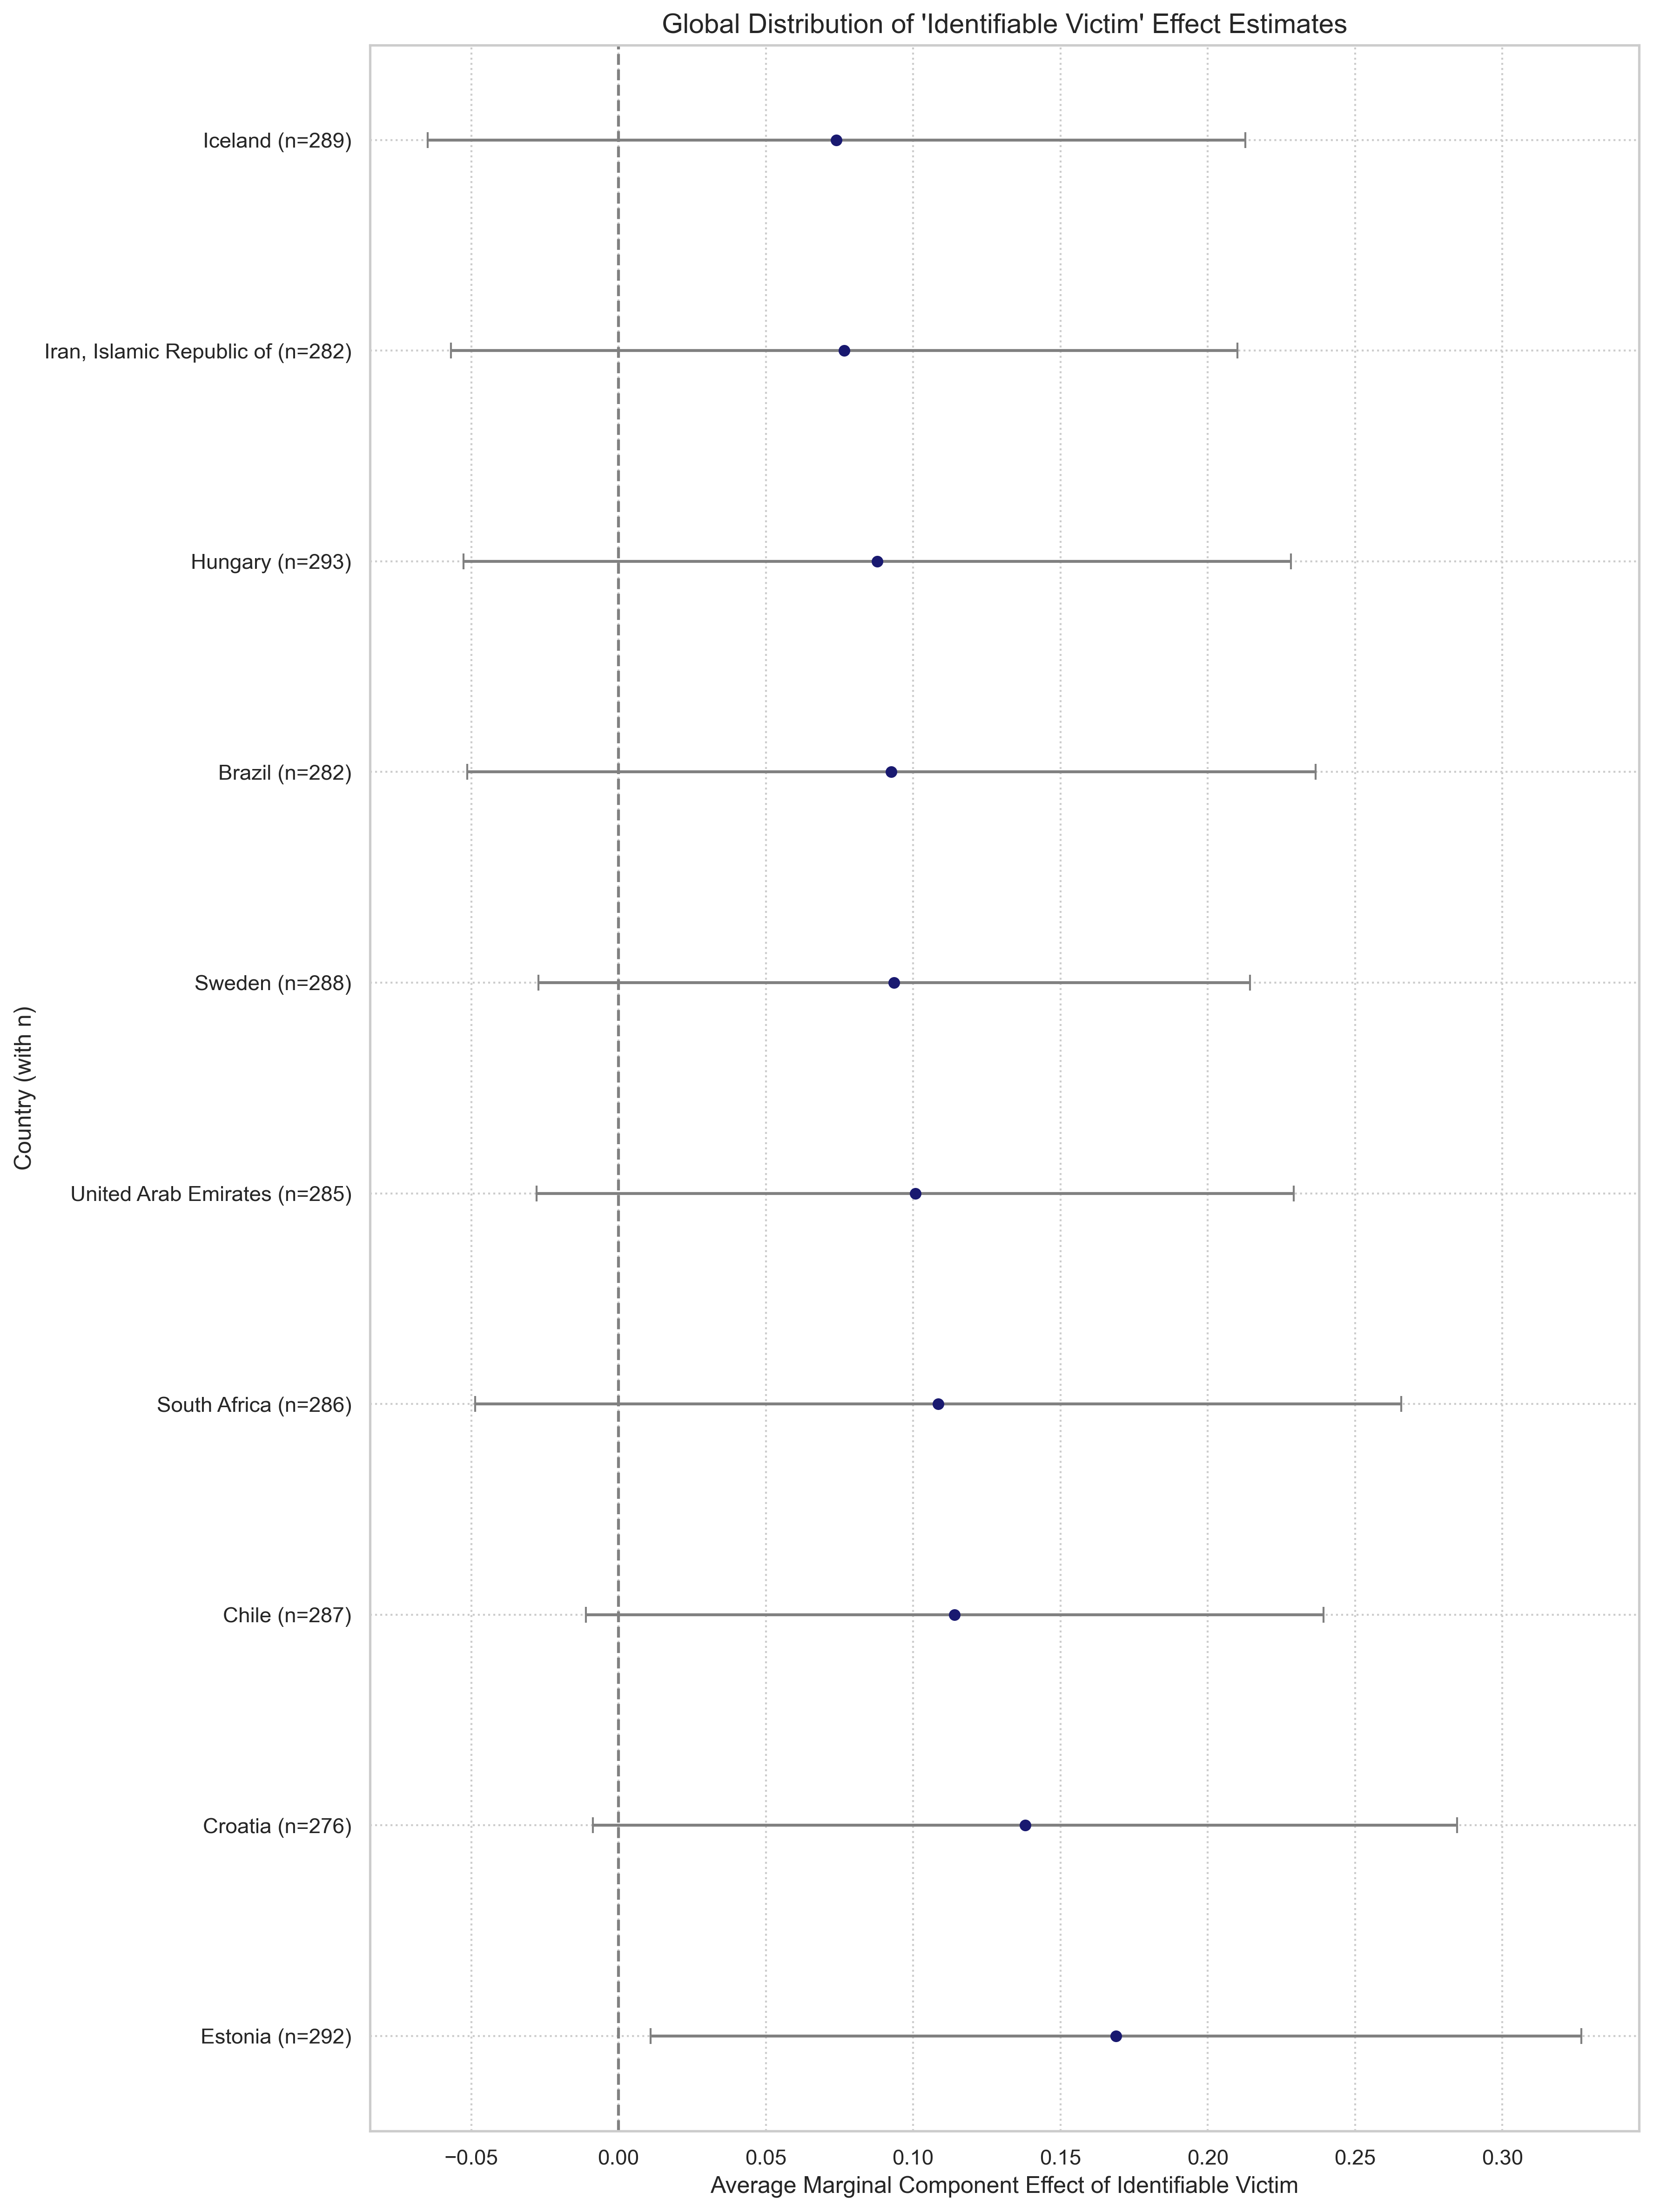

In [254]:
# Run logistic regressions by country and compute AMEs for gender
ame_results = []

for location in df['country'].unique():
    subdf = df[df['country'] == location]
    if subdf['don_gender'].nunique() < 2:
        continue
    try:
        model = smf.logit(
            formula='chosen_option ~ don_gender + C(don_age) + C(don_cause) + C(don_brand) + C(don_identifiability) + don_num_recipients',
            data=subdf
        ).fit(disp=False)
        me = model.get_margeff(at='overall', method='dydx', dummy=True)  
        # Get average of all marginal effects related to don_cause
        cause_mfx = me.summary_frame().filter(like='don_identifiability', axis=0)
        avg_ame = cause_mfx['dy/dx'].item()
        avg_se = cause_mfx['Std. Err.'].item()
        ci_low = avg_ame - 1.96 * avg_se
        ci_high = avg_ame + 1.96 * avg_se

        ame_results.append({
            'location': location,
            'ame': avg_ame,
            'ci_low': ci_low,
            'ci_high': ci_high,
            'stderr': avg_se,
            'n': len(subdf)
        })
    except Exception:
        continue
# Convert results to DataFrame
ame_df = pd.DataFrame(ame_results)
ame_df['label'] = ame_df.apply(lambda row: f"{row['location']} (n={row['n']})", axis=1)
#ame_df = ame_df.sort_values('ame')
ame_df = ame_df.sort_values('ame',ascending=False).head(10)

# Plot with enhancements
plt.figure(figsize=(12, 16), dpi=300)
plt.errorbar(
    ame_df['ame'], ame_df['label'],
    xerr=[ame_df['ame'] - ame_df['ci_low'], ame_df['ci_high'] - ame_df['ame']],
    fmt='o', color='midnightblue', ecolor='gray', capsize=4, markersize=5
)
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Average Marginal Component Effect of Identifiable Victim", fontsize=12)
plt.ylabel("Country (with n)", fontsize=12)
plt.title("Global Distribution of 'Identifiable Victim' Effect Estimates", fontsize=14)
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

## Age

In [207]:
df['age'].value_counts()

18.0    6287
23.0    1454
22.0    1313
25.0    1276
20.0    1226
26.0    1192
24.0    1172
27.0    1158
21.0    1155
19.0    1150
28.0     880
29.0     866
30.0     763
31.0     623
32.0     618
33.0     480
34.0     435
36.0     378
35.0     355
37.0     215
38.0     203
39.0     137
40.0     113
41.0     108
42.0      47
43.0      23
45.0      22
48.0      21
46.0      11
44.0      11
Name: age, dtype: int64

## don_num_recipients

/Users/rajasunkara/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rajasunkara/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rajasunkara/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rajasunkara/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


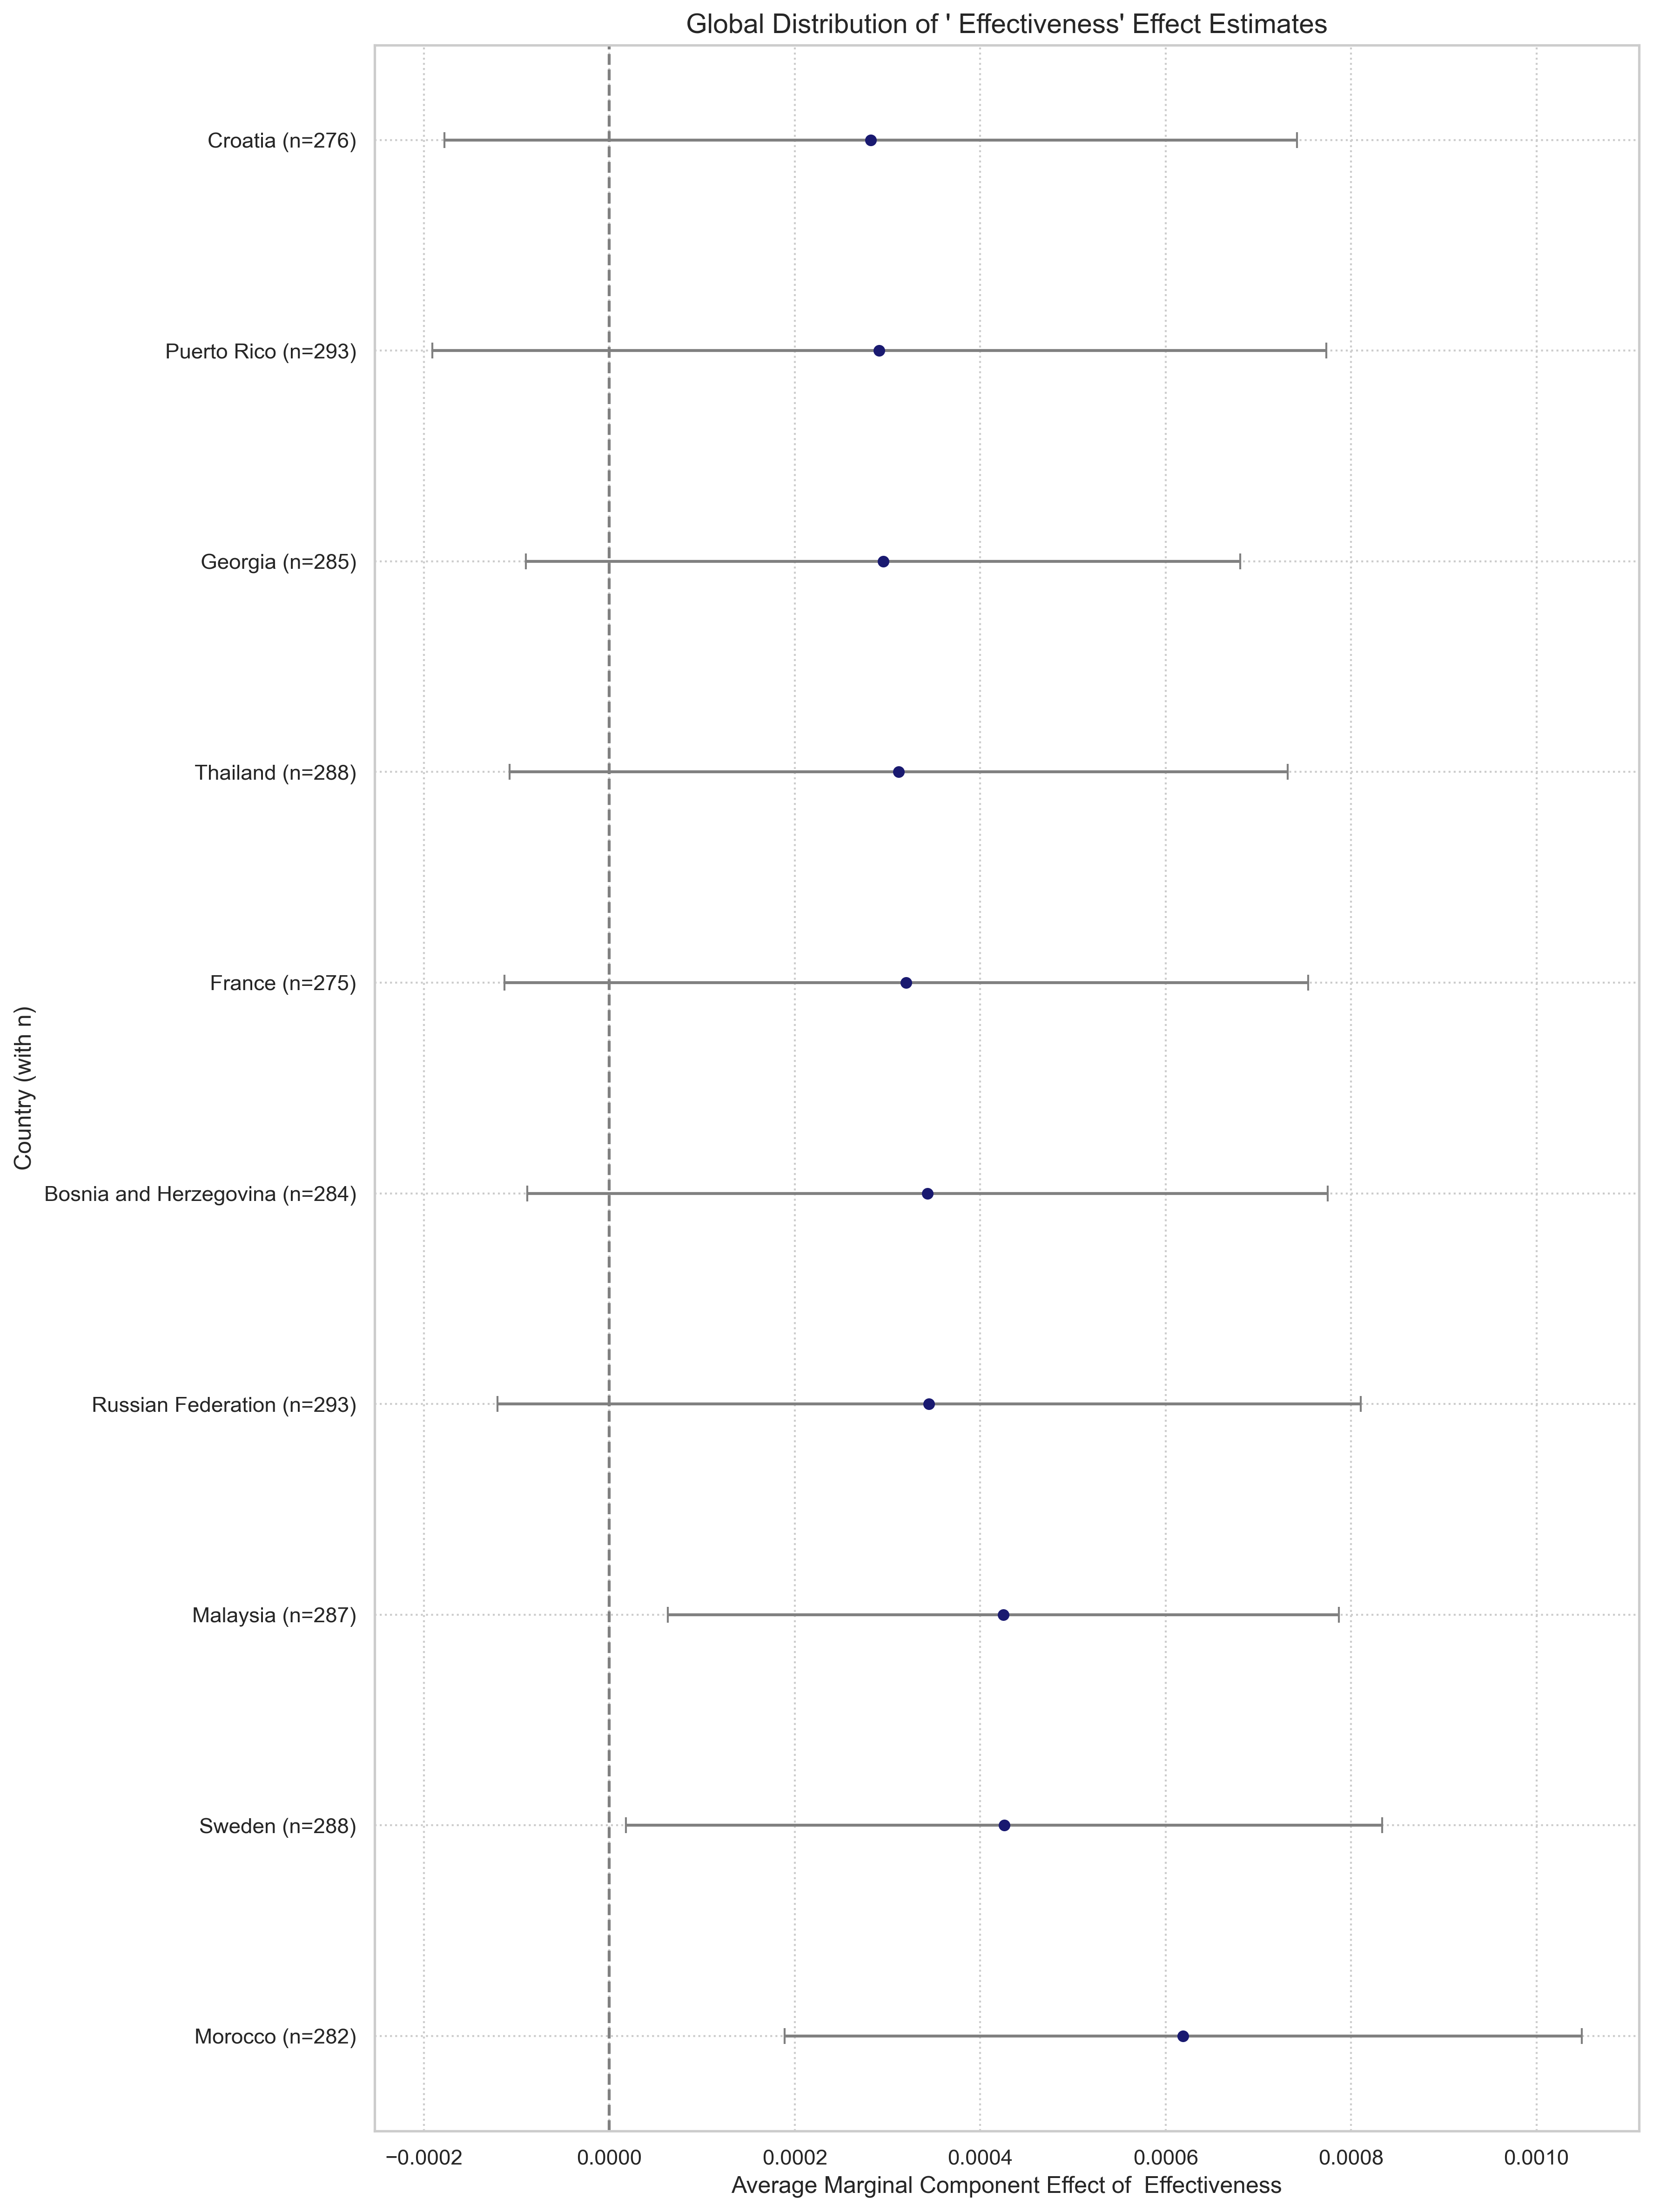

In [255]:
# Run logistic regressions by country and compute AMEs for gender
ame_results = []

for location in df['country'].unique():
    subdf = df[df['country'] == location]
    if subdf['don_gender'].nunique() < 2:
        continue
    try:
        model = smf.logit(
            formula='chosen_option ~ don_gender + C(don_age) + C(don_cause) + C(don_brand) + C(don_identifiability) + don_num_recipients',
            data=subdf
        ).fit(disp=False)
        me = model.get_margeff(at='overall', method='dydx', dummy=True)  
        # Get average of all marginal effects related to don_cause
        cause_mfx = me.summary_frame().filter(like='don_num_recipients', axis=0)
        avg_ame = cause_mfx['dy/dx'].abs().mean()
        avg_se = cause_mfx['Std. Err.'].mean()
        ci_low = avg_ame - 1.96 * avg_se
        ci_high = avg_ame + 1.96 * avg_se

        ame_results.append({
            'location': location,
            'ame': avg_ame,
            'ci_low': ci_low,
            'ci_high': ci_high,
            'stderr': avg_se,
            'n': len(subdf)
        })
    except Exception:
        continue
# Convert results to DataFrame
ame_df = pd.DataFrame(ame_results)
ame_df['label'] = ame_df.apply(lambda row: f"{row['location']} (n={row['n']})", axis=1)
#ame_df = ame_df.sort_values('ame')
ame_df = ame_df.sort_values('ame',ascending=False).head(10)

# Plot with enhancements
plt.figure(figsize=(12, 16), dpi=300)
plt.errorbar(
    ame_df['ame'], ame_df['label'],
    xerr=[ame_df['ame'] - ame_df['ci_low'], ame_df['ci_high'] - ame_df['ame']],
    fmt='o', color='midnightblue', ecolor='gray', capsize=4, markersize=5
)
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Average Marginal Component Effect of  Effectiveness", fontsize=12)
plt.ylabel("Country (with n)", fontsize=12)
plt.title("Global Distribution of ' Effectiveness' Effect Estimates", fontsize=14)
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

In [181]:
df.columns

Index(['age', 'gender', 'income', 'education', 'political_leaning',
       'religious_level', 'donated_before', 'donation_frequency',
       'trust_charities', 'charities_rated_by_effectiveness',
       'objective_measures_help', 'charities_match_my_values', 'country',
       'province', 'chosen_option', 'don_gender', 'don_age',
       'don_identifiability', 'don_num_recipients', 'don_cause', 'don_brand',
       'don_location', 'don_region'],
      dtype='object')

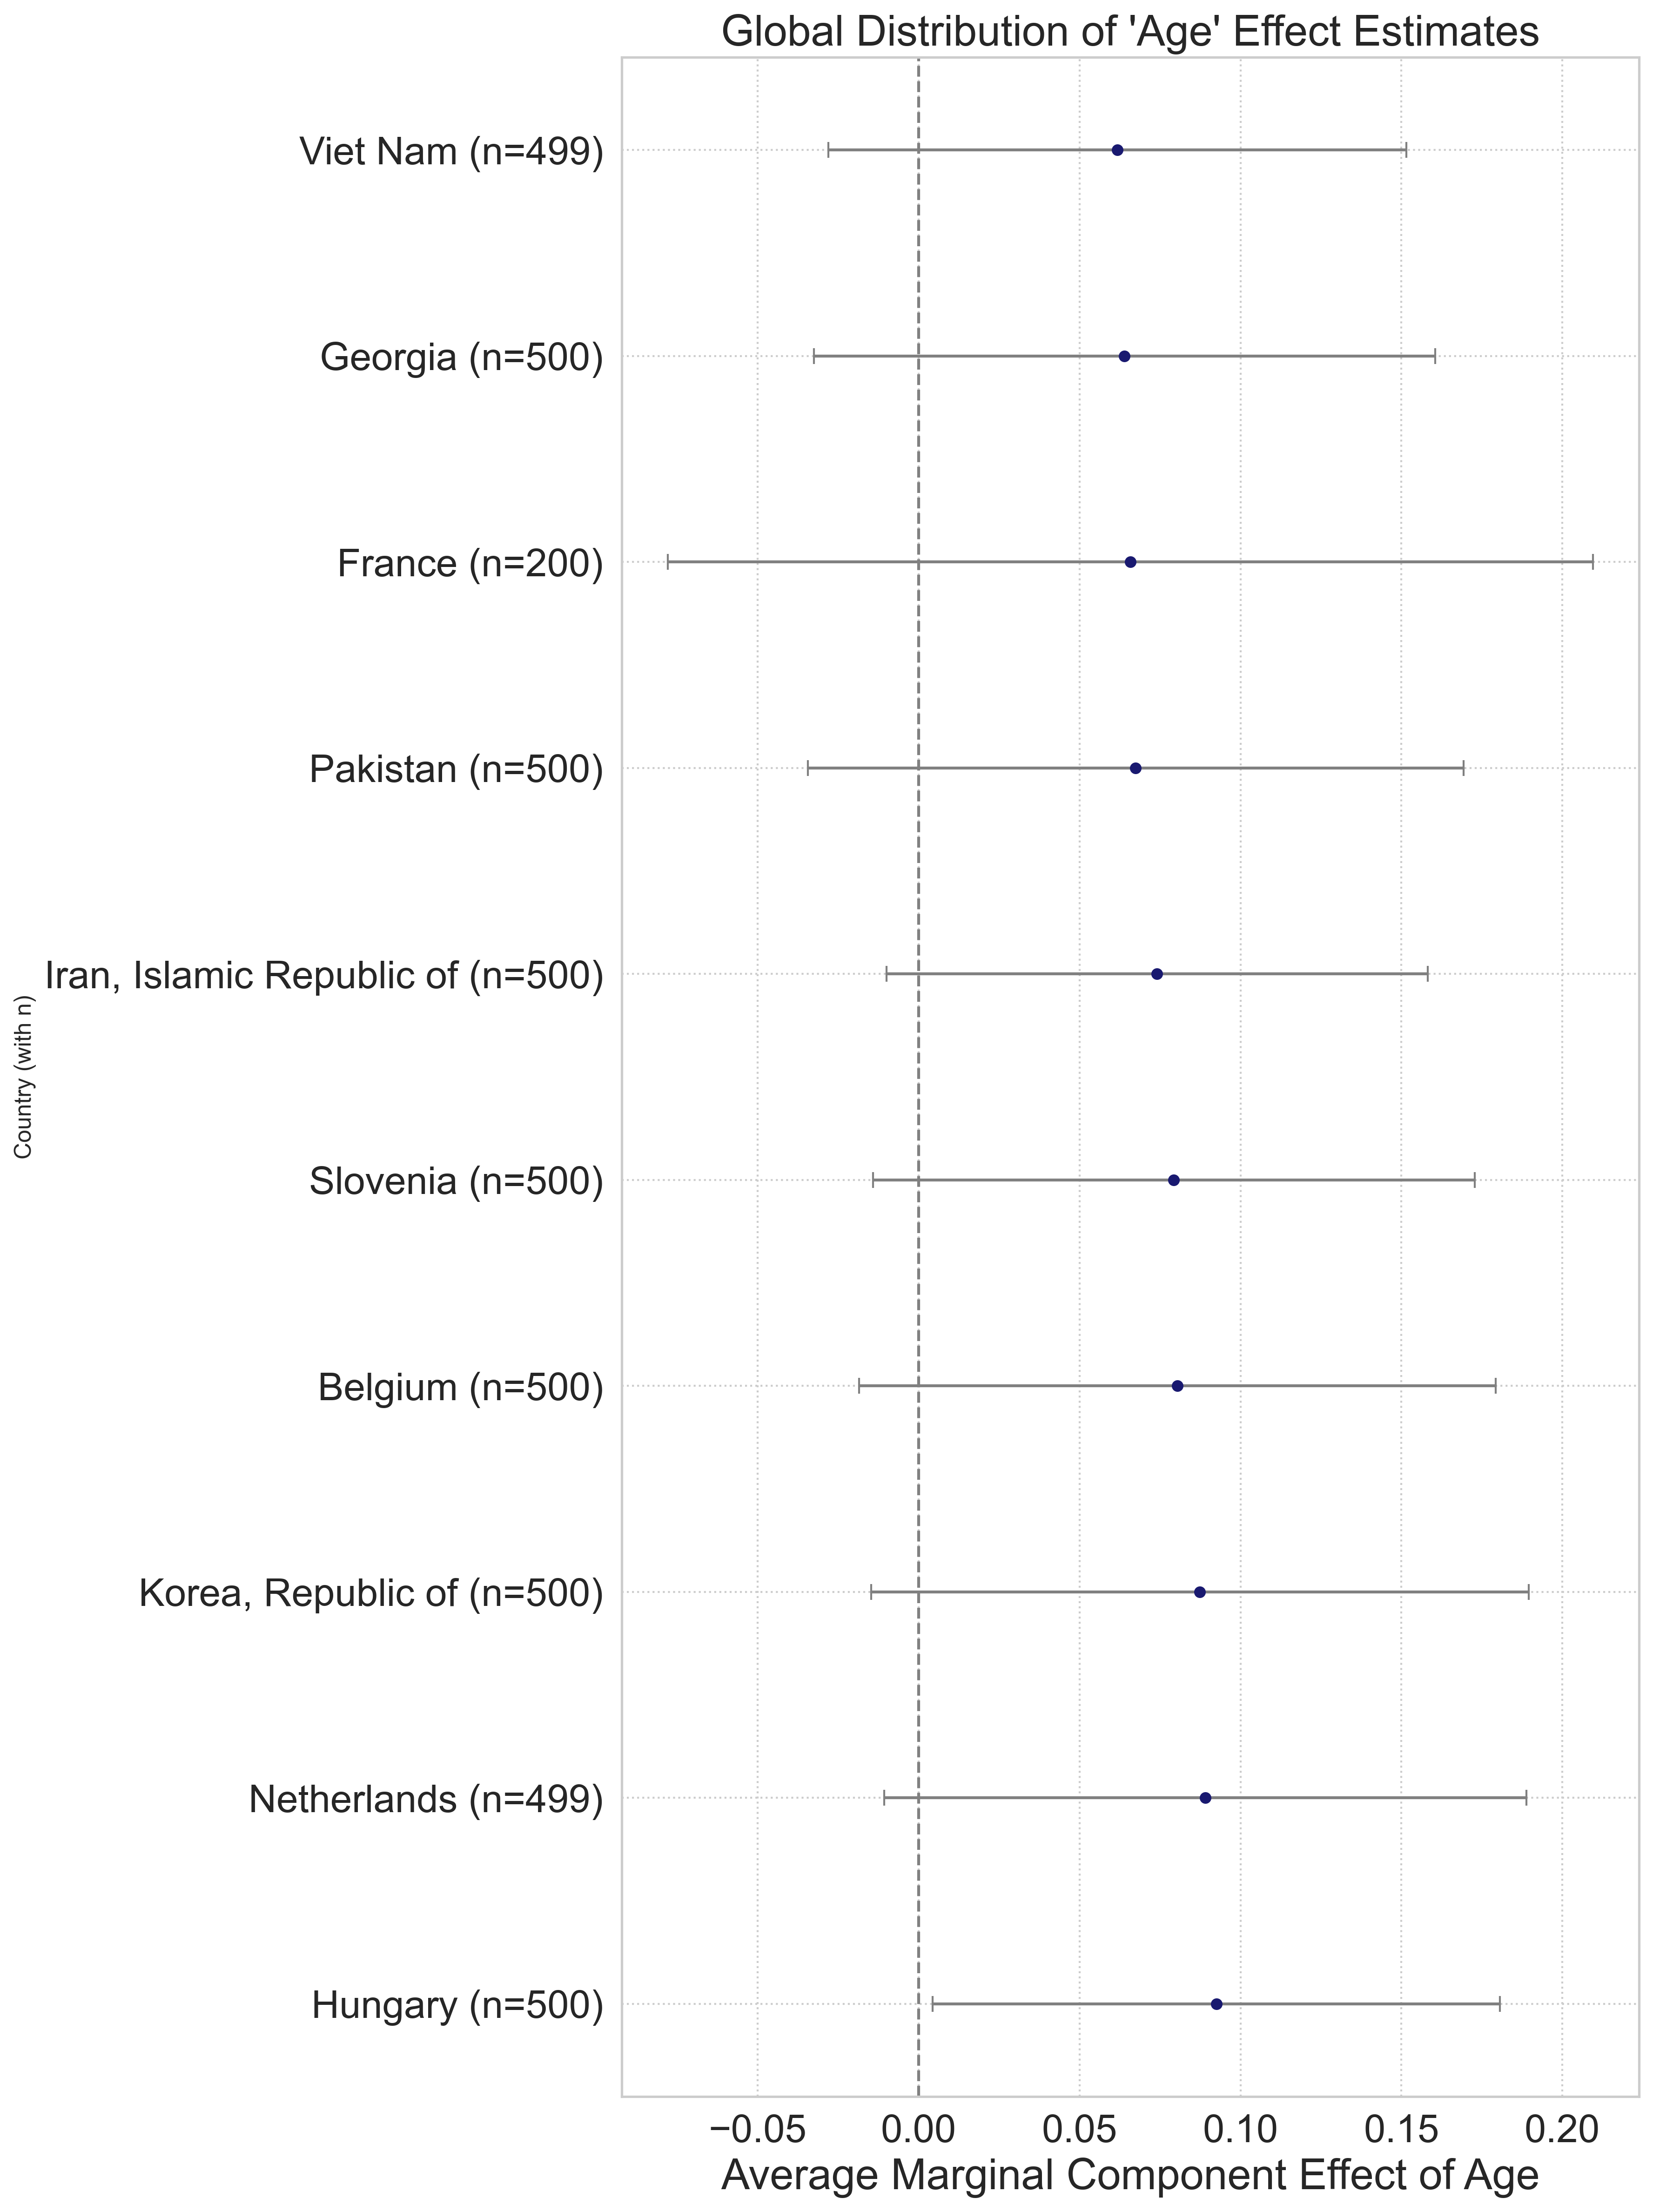

In [260]:
# Run logistic regressions by country and compute AMEs for gender
ame_results = []

for location in df['country'].unique():
    subdf = df[df['country'] == location]
    if subdf['don_gender'].nunique() < 2:
        continue
    try:
        model = smf.logit(
            formula='chosen_option ~ don_gender + C(don_age) + C(don_cause) + C(don_brand) + C(don_identifiability) + don_num_recipients',
            data=subdf
        ).fit(disp=False)
        me = model.get_margeff(at='overall', method='dydx', dummy=True)  
        # Get average of all marginal effects related to don_cause
        cause_mfx = me.summary_frame().filter(like='don_age', axis=0)
        avg_ame = cause_mfx['dy/dx'].abs().mean()
        avg_se = cause_mfx['Std. Err.'].mean()
        ci_low = avg_ame - 1.96 * avg_se
        ci_high = avg_ame + 1.96 * avg_se

        ame_results.append({
            'location': location,
            'ame': avg_ame,
            'ci_low': ci_low,
            'ci_high': ci_high,
            'stderr': avg_se,
            'n': len(subdf)
        })
    except Exception:
        continue
# Convert results to DataFrame
ame_df = pd.DataFrame(ame_results)
ame_df['label'] = ame_df.apply(lambda row: f"{row['location']} (n={row['n']})", axis=1)
#ame_df = ame_df.sort_values('ame')
ame_df = ame_df.sort_values('ame',ascending=False).head(10)

# Plot with enhancements
plt.figure(figsize=(12, 16), dpi=300)
plt.errorbar(
    ame_df['ame'], ame_df['label'],
    xerr=[ame_df['ame'] - ame_df['ci_low'], ame_df['ci_high'] - ame_df['ame']],
    fmt='o', color='midnightblue', ecolor='gray', capsize=4, markersize=5
)
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Average Marginal Component Effect of Age", fontsize=22)
plt.ylabel("Country (with n)", fontsize=12)
plt.title("Global Distribution of 'Age' Effect Estimates", fontsize=22)
plt.grid(True, linestyle=':')
plt.yticks(fontsize=20)  # Adjust font size as needed
plt.xticks(fontsize=20)
plt.tight_layout()
plt.show()

/Users/rajasunkara/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predictor    C(don_age)[T.senior]
ame                     -0.006913
stderr                   0.007251
z                       -0.953366
Pr(>|z|)                 0.340405
ci_low                  -0.021125
ci_high                  0.007299
group                         Age
label                Age: Senior]
Name: 0, dtype: object
predictor    C(don_age)[T.child]
ame                     0.004694
stderr                  0.006924
z                       0.677841
Pr(>|z|)                0.497872
ci_low                 -0.008878
ci_high                 0.018265
group                        Age
label                Age: Child]
Name: 1, dtype: object
predictor    C(don_brand)[T.low-recognition]
ame                                -0.012112
stderr                                0.0058
z                                  -2.088244
Pr(>|z|)                            0.036776
ci_low                             -0.023481
ci_high                            -0.000744
group                               

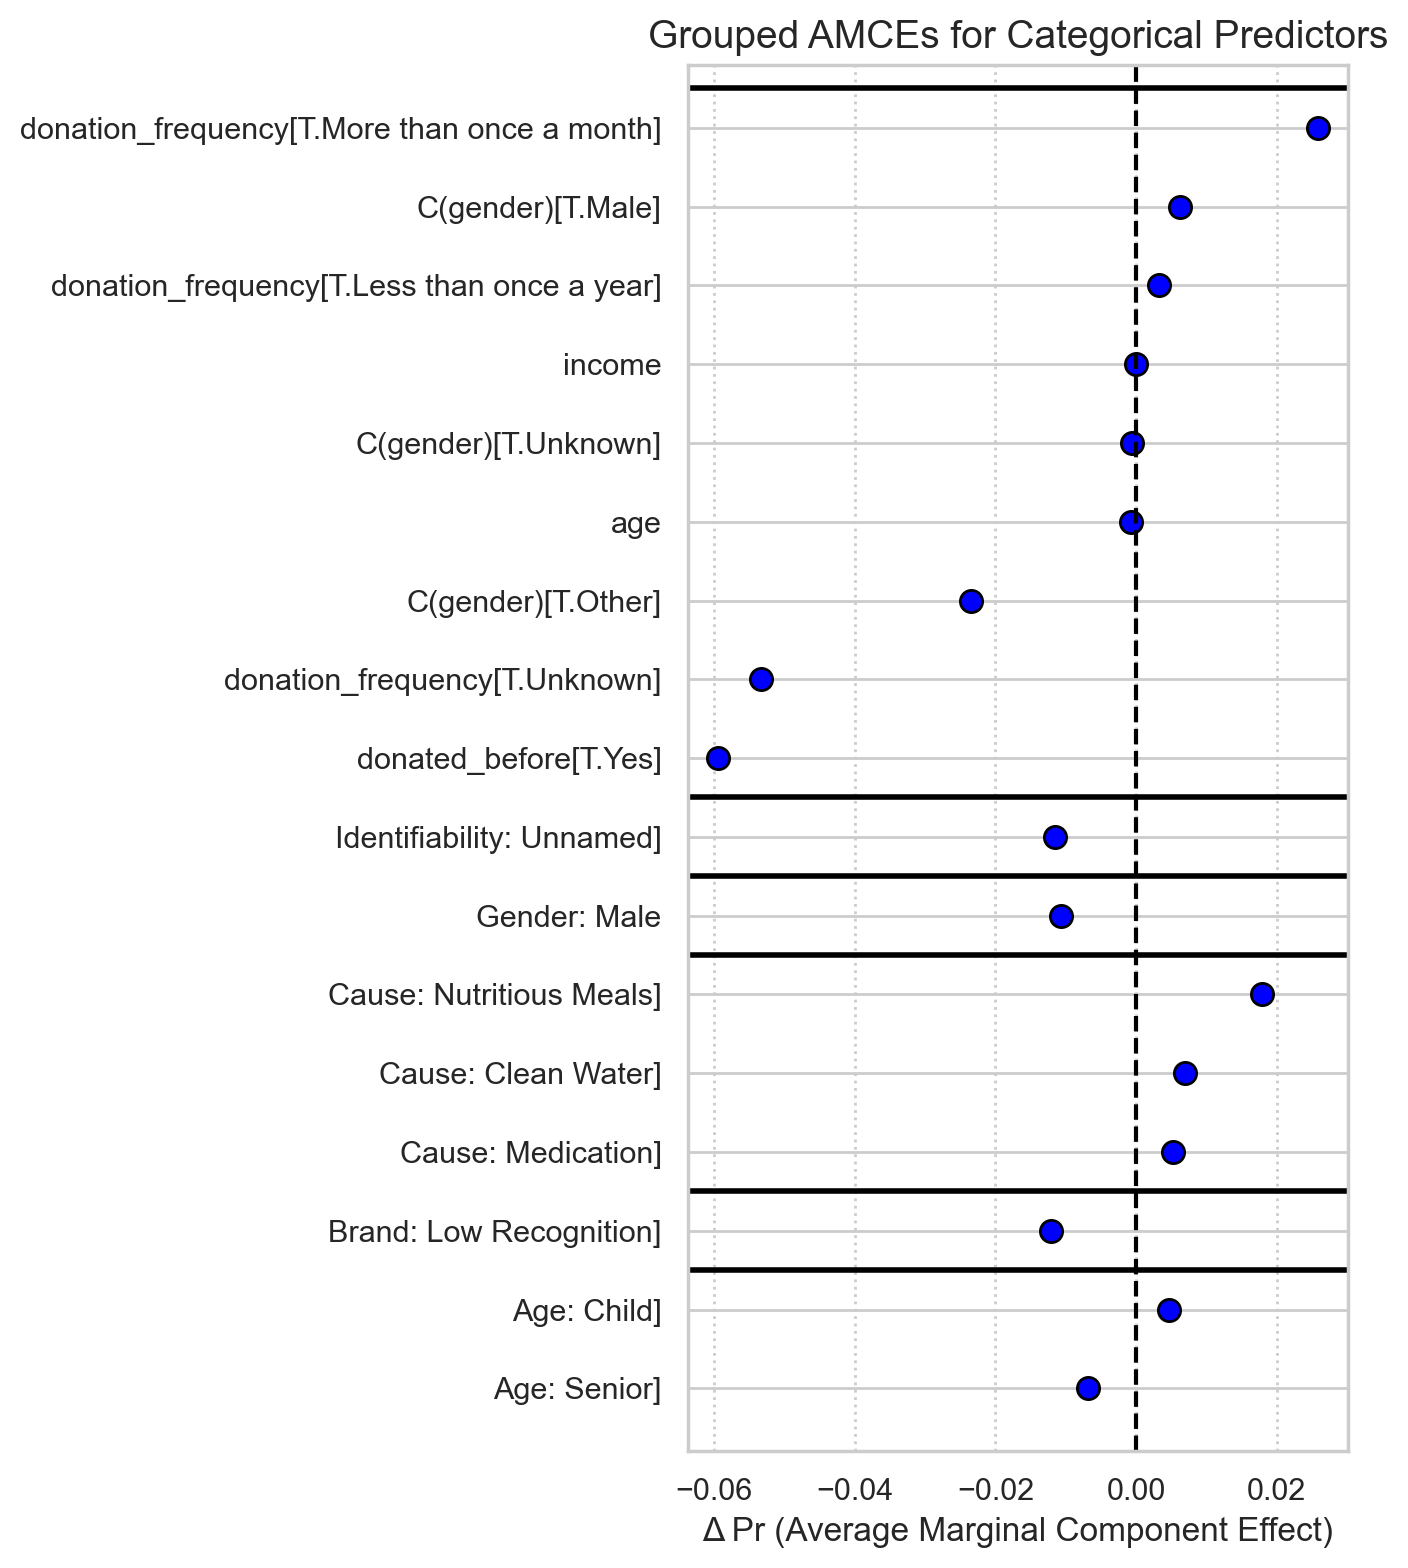

In [261]:
# Fit model
model = smf.logit(
    formula= 'chosen_option ~ C(don_gender) + C(don_cause) + C(don_brand) + C(don_identifiability) + C(don_age)+ C(gender) + age + income + donated_before + donation_frequency', 
             #'chosen_option ~ C(don_gender) + C(don_cause) + C(don_brand) + C(don_identifiability) + C(don_age)',
    data=df
).fit(disp=False)


# Compute marginal effects
mfx = model.get_margeff(at='overall', method='dydx', dummy=True)
mfx_df = mfx.summary_frame().reset_index()

# Clean and relabel
mfx_df = mfx_df.rename(columns={
    'index': 'predictor',
    'dy/dx': 'ame',
    'Std. Err.': 'stderr',
    'Conf. Int. Low': 'ci_low',
    'Cont. Int. Hi.': 'ci_high'
})

# Group assignment
def get_group(label):
    if 'don_gender' in label:
        return 'Gender'
    elif 'don_cause' in label:
        return 'Charitable Cause'
    elif 'don_brand' in label:
        return 'Brand'
    elif 'don_identifiability' in label:
        return 'Identifiability'
    elif 'don_age' in label:
        return 'Age'
    else:
        return 'Other'

mfx_df['group'] = mfx_df['predictor'].apply(get_group)

# Human-readable labels
def relabel_predictor(p):
    if 'don_gender' in p:
        return 'Gender: Male'
    elif 'don_cause' in p:
        return 'Cause: ' + p.split('T.')[-1].replace('_', ' ').title()
    elif 'don_brand' in p:
        return 'Brand: ' + p.split('T.')[-1].replace('-', ' ').title()
    elif 'don_identifiability' in p:
        return 'Identifiability: ' + p.split('T.')[-1].title()
    elif 'don_age' in p:
        return 'Age: ' + p.split('T.')[-1].title()
    else:
        return p

mfx_df['label'] = mfx_df['predictor'].apply(relabel_predictor)

# Sort and group boundaries
mfx_df = mfx_df.sort_values(by=['group', 'ame']).reset_index(drop=True)
group_boundaries = mfx_df.groupby('group').apply(lambda x: x.index.max() + 0.5).values

# Replot without confidence intervals and using solid blue dots
plt.figure(figsize=(7, 8), dpi=200)
sns.set(style="whitegrid")

# Plot blue dots only, no CI lines
for idx, row in mfx_df.iterrows():
    print(row)
    plt.plot(row['ame'], idx, 'o', markersize=8, color='blue', markeredgecolor='black')

# Thick horizontal lines between groups
for boundary in group_boundaries:
    plt.axhline(y=boundary, color='black', linestyle='-', linewidth=2)

# Axis settings
plt.yticks(ticks=range(len(mfx_df)), labels=mfx_df['label'])
plt.axvline(0, color='black', linestyle='--')
plt.xlabel("Δ Pr (Average Marginal Component Effect)", fontsize=12)
plt.title("Grouped AMCEs for Categorical Predictors", fontsize=14)
plt.grid(axis='x', linestyle=':')
plt.tight_layout()
plt.show()


In [146]:
# Compute the overall marginal effect of `don_cause` (as a categorical variable) by country

cause_cat_results = []

for country in df_ame['don_location'].dropna().unique():
    subdf = df_ame[df_ame['don_location'] == country]
    if subdf['don_cause'].nunique() < 2:
        continue
    try:
        # Fit logistic regression with don_cause as categorical
        model = smf.logit(
            formula='chosen_option_numeric ~ C(don_cause) + C(don_age) + C(don_brand) + C(don_identifiability) + don_num_recipients',
            data=subdf
        ).fit(disp=False)

        # Compute AME for all cause categories together
        margeff = model.get_margeff(at='overall', method='dydx', dummy=True)
        
        # Get average of all marginal effects related to don_cause
        cause_mfx = margeff.summary_frame().filter(like='don_cause', axis=0)
        avg_ame = cause_mfx['dy/dx'].mean()
        avg_se = cause_mfx['Std. Err.'].mean()
        ci_low = avg_ame - 1.96 * avg_se
        ci_high = avg_ame + 1.96 * avg_se

        cause_cat_results.append({
            'country': country,
            'ame': avg_ame,
            'ci_low': ci_low,
            'ci_high': ci_high,
            'stderr': avg_se,
            'n': len(subdf)
        })

    except Exception as e:
        print(f"Skipped {country} due to error: {e}")

# Create DataFrame
cause_cat_df = pd.DataFrame(cause_cat_results).sort_values('ame')

# Plot
plt.figure(figsize=(10, 14))
plt.errorbar(cause_cat_df['ame'], cause_cat_df['country'],
             xerr=[cause_cat_df['ame'] - cause_cat_df['ci_low'], 
                   cause_cat_df['ci_high'] - cause_cat_df['ame']],
             fmt='o', capsize=4)
plt.axvline(0, color='gray', linestyle='--')
plt.title("Global Distribution of Charitable Cause Effect Estimates")
plt.xlabel("Average Marginal Effect of `don_cause` (mean across categories)")
plt.ylabel("Country (don_location)")
plt.grid(True)
plt.tight_layout()
plt.show()


Skipped Western Europe due to error: Error evaluating factor: NameError: name 'chosen_option_numeric' is not defined
    chosen_option_numeric ~ C(don_cause) + C(don_age) + C(don_brand) + C(don_identifiability) + don_num_recipients
    ^^^^^^^^^^^^^^^^^^^^^
Skipped North America due to error: Error evaluating factor: NameError: name 'chosen_option_numeric' is not defined
    chosen_option_numeric ~ C(don_cause) + C(don_age) + C(don_brand) + C(don_identifiability) + don_num_recipients
    ^^^^^^^^^^^^^^^^^^^^^
Skipped East Asia due to error: Error evaluating factor: NameError: name 'chosen_option_numeric' is not defined
    chosen_option_numeric ~ C(don_cause) + C(don_age) + C(don_brand) + C(don_identifiability) + don_num_recipients
    ^^^^^^^^^^^^^^^^^^^^^
Skipped South Africa due to error: Error evaluating factor: NameError: name 'chosen_option_numeric' is not defined
    chosen_option_numeric ~ C(don_cause) + C(don_age) + C(don_brand) + C(don_identifiability) + don_num_recipients
  

KeyError: 'ame'

In [38]:


# Prepare the dataframe (no need to extract don_* fields; they are already present)
# Filter for valid gender
df = df[df['don_gender'].isin(['male', 'female'])]
df['don_gender'] = df['don_gender'].map({'female': 0, 'male': 1})
df['don_num_recipients'] = pd.to_numeric(df['don_num_recipients'], errors='coerce')
df = df.dropna(subset=['chosen_option_numeric', 'don_cause', 'don_location'])

# Run logistic model for each country and extract marginal effects for don_cause categories
individual_cause_results = []

for country in df['don_location'].dropna().unique():
    subdf = df[df['don_location'] == country]
    if subdf['don_cause'].nunique() < 2:
        continue
    try:
        model = smf.logit(
            formula='chosen_option_numeric ~ C(don_cause) + C(don_age) + C(don_brand) + C(don_identifiability) + don_num_recipients',
            data=subdf
        ).fit(disp=False)

        margeff = model.get_margeff(at='overall', method='dydx', dummy=True)
        cause_mfx = margeff.summary_frame().filter(like='don_cause', axis=0)

        for cause_row, row_data in cause_mfx.iterrows():
            individual_cause_results.append({
                'country': country,
                'cause': cause_row.replace('don_cause', '').strip('[]'),
                'ame': row_data['dy/dx'],
                'ci_low': row_data['Conf. Int. Low'],
                'ci_high': row_data['Cont. Int. Hi.'],
                'stderr': row_data['Std. Err.']
            })
    except Exception as e:
        print(f"Skipped {country} due to error: {e}")

# Rebuild the DataFrame
indiv_cause_df = pd.DataFrame(individual_cause_results)
indiv_cause_df['ame_abs'] = indiv_cause_df['ame'].abs()

# Proceed to compute and plot the average |AME| with error bars
summary_df = (
    indiv_cause_df.groupby('country')['ame_abs']
    .agg(['mean', 'std'])
    .reset_index()
    .rename(columns={'mean': 'ame_avg_abs', 'std': 'ame_std'})
)

# Compute CI bounds
summary_df['ci_low'] = (summary_df['ame_avg_abs'] - 1.96 * summary_df['ame_std']).clip(lower=0)
summary_df['ci_high'] = summary_df['ame_avg_abs'] + 1.96 * summary_df['ame_std']

# Plot
plt.figure(figsize=(10, 14))
plt.errorbar(summary_df['ame_avg_abs'], summary_df['country'],
             xerr=[summary_df['ame_avg_abs'] - summary_df['ci_low'],
                   summary_df['ci_high'] - summary_df['ame_avg_abs']],
             fmt='o', capsize=4)
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Mean |AME| of `don_cause` across categories (± 1.96×STD)")
plt.ylabel("Country (don_location)")
plt.title("Average |Marginal Effect| of Donation Cause by Country with CI")
plt.grid(True)
plt.tight_layout()
plt.show()



/var/folders/6h/pfv0s7y93llgs2rz061pn2p00000gn/T/ipykernel_73946/3107783747.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['don_gender'] = df['don_gender'].map({'female': 0, 'male': 1})
/var/folders/6h/pfv0s7y93llgs2rz061pn2p00000gn/T/ipykernel_73946/3107783747.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['don_num_recipients'] = pd.to_numeric(df['don_num_recipients'], errors='coerce')


KeyError: ['chosen_option_numeric']

In [39]:
# Helper function to compute and return |AME| summary for a given categorical variable
def compute_mean_abs_ame_by_country(df, variable):
    results = []

    for country in df['don_location'].dropna().unique():
        subdf = df[df['don_location'] == country]
        if subdf[variable].nunique() < 2:
            continue
        try:
            model = smf.logit(
                formula=f'chosen_option_numeric ~ C({variable}) + C(don_age) + C(don_cause) + C(don_identifiability) + don_num_recipients',
                data=subdf
            ).fit(disp=False)

            margeff = model.get_margeff(at='overall', method='dydx', dummy=True)
            mfx = margeff.summary_frame().filter(like=variable, axis=0)

            for row_name, row in mfx.iterrows():
                results.append({
                    'country': country,
                    'category': row_name.replace(variable, '').strip('[]'),
                    'ame': row['dy/dx'],
                    'stderr': row['Std. Err.']
                })
        except Exception as e:
            print(f"Skipped {country} for {variable} due to error: {e}")

    df_res = pd.DataFrame(results)
    df_res['ame_abs'] = df_res['ame'].abs()
    
    summary = (
        df_res.groupby('country')['ame_abs']
        .agg(['mean', 'std'])
        .reset_index()
        .rename(columns={'mean': 'ame_avg_abs', 'std': 'ame_std'})
    )
    summary['ci_low'] = (summary['ame_avg_abs'] - 1.96 * summary['ame_std']).clip(lower=0)
    summary['ci_high'] = summary['ame_avg_abs'] + 1.96 * summary['ame_std']
    return summary

# Compute for don_brand
brand_summary = compute_mean_abs_ame_by_country(df, 'don_brand')

# Compute for don_identifiability
id_summary = compute_mean_abs_ame_by_country(df, 'don_identifiability')

# Plot for don_brand
plt.figure(figsize=(10, 14))
plt.errorbar(brand_summary['ame_avg_abs'], brand_summary['country'],
             xerr=[brand_summary['ame_avg_abs'] - brand_summary['ci_low'],
                   brand_summary['ci_high'] - brand_summary['ame_avg_abs']],
             fmt='o', capsize=4)
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Mean |AME| of `don_brand` across categories (± 1.96×STD)")
plt.ylabel("Country (don_location)")
plt.title("Average |Marginal Effect| of Donation Brand by Country")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for don_identifiability
plt.figure(figsize=(10, 14))
plt.errorbar(id_summary['ame_avg_abs'], id_summary['country'],
             xerr=[id_summary['ame_avg_abs'] - id_summary['ci_low'],
                   id_summary['ci_high'] - id_summary['ame_avg_abs']],
             fmt='o', capsize=4)
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Mean |AME| of `don_identifiability` across categories (± 1.96×STD)")
plt.ylabel("Country (don_location)")
plt.title("Average |Marginal Effect| of Donation Identifiability by Country")
plt.grid(True)
plt.tight_layout()
plt.show()


Skipped East Asia for don_brand due to error: Error evaluating factor: NameError: name 'chosen_option_numeric' is not defined
    chosen_option_numeric ~ C(don_brand) + C(don_age) + C(don_cause) + C(don_identifiability) + don_num_recipients
    ^^^^^^^^^^^^^^^^^^^^^
Skipped Western Europe for don_brand due to error: Error evaluating factor: NameError: name 'chosen_option_numeric' is not defined
    chosen_option_numeric ~ C(don_brand) + C(don_age) + C(don_cause) + C(don_identifiability) + don_num_recipients
    ^^^^^^^^^^^^^^^^^^^^^
Skipped North Africa for don_brand due to error: Error evaluating factor: NameError: name 'chosen_option_numeric' is not defined
    chosen_option_numeric ~ C(don_brand) + C(don_age) + C(don_cause) + C(don_identifiability) + don_num_recipients
    ^^^^^^^^^^^^^^^^^^^^^
Skipped Central Africa for don_brand due to error: Error evaluating factor: NameError: name 'chosen_option_numeric' is not defined
    chosen_option_numeric ~ C(don_brand) + C(don_age) + C(do

KeyError: 'ame'